# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0K/60.0K [05:00<00:00, 199File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

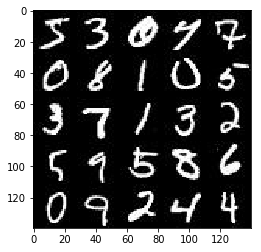

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

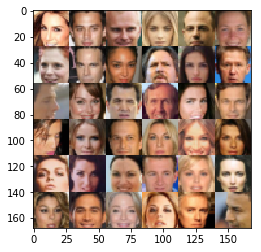

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    #Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
    inputs_real = tf.placeholder(tf.float32, 
                                  [None, image_width, image_height, image_channels], 
                                  name='input_real') 
    
    #Z input placeholder with rank 2 using z_dim.
    z_input = tf.placeholder(tf.float32, 
                               [None, z_dim], 
                               name='z_input')
    
    #Learning rate placeholder with rank 0.
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        l3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #l4 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(l4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)
        
        # Flatten it
        #flat = tf.reshape(relu4, (-1, 4*4*512))
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):

        l1 = tf.layers.dense(z, 4*4*512)
        l1 = tf.reshape(l1, (-1, 4, 4, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        # 4x4x512 now
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 4, strides=1, padding='valid')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        # 7x7x256 now
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:


def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import pickle as pkl
samples = []
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    total_data_size, image_width, image_height, image_channels = data_shape

    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every_step = 20
    show_every_step = 200
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps += 1

                # Generate random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = batch_images*2 
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})

                if steps % print_every_step == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    losses.append((train_loss_d, train_loss_g))
                    print("Epoch {}/{} Batch Step {}...".format(epoch_i, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every_step == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
        print('Done Training!')
        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 Batch Step 20... Discriminator Loss: 0.4721... Generator Loss: 3.3289
Epoch 0/2 Batch Step 40... Discriminator Loss: 0.4290... Generator Loss: 4.4371
Epoch 0/2 Batch Step 60... Discriminator Loss: 1.8426... Generator Loss: 0.6695
Epoch 0/2 Batch Step 80... Discriminator Loss: 0.5504... Generator Loss: 3.2109
Epoch 0/2 Batch Step 100... Discriminator Loss: 0.5576... Generator Loss: 1.8952
Epoch 0/2 Batch Step 120... Discriminator Loss: 1.6560... Generator Loss: 0.5779
Epoch 0/2 Batch Step 140... Discriminator Loss: 2.8544... Generator Loss: 0.1152
Epoch 0/2 Batch Step 160... Discriminator Loss: 1.6180... Generator Loss: 0.4298
Epoch 0/2 Batch Step 180... Discriminator Loss: 3.3153... Generator Loss: 0.0792
Epoch 0/2 Batch Step 200... Discriminator Loss: 2.8349... Generator Loss: 0.1745


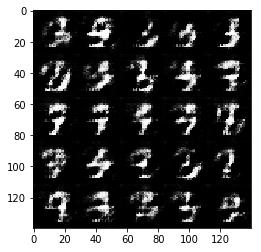

Epoch 0/2 Batch Step 220... Discriminator Loss: 2.3162... Generator Loss: 0.2596
Epoch 0/2 Batch Step 240... Discriminator Loss: 1.5091... Generator Loss: 0.5600
Epoch 0/2 Batch Step 260... Discriminator Loss: 2.1348... Generator Loss: 0.3164
Epoch 0/2 Batch Step 280... Discriminator Loss: 1.3810... Generator Loss: 1.1529
Epoch 0/2 Batch Step 300... Discriminator Loss: 1.7866... Generator Loss: 0.4008
Epoch 0/2 Batch Step 320... Discriminator Loss: 2.8484... Generator Loss: 0.0944
Epoch 0/2 Batch Step 340... Discriminator Loss: 1.5398... Generator Loss: 0.6014
Epoch 0/2 Batch Step 360... Discriminator Loss: 1.0889... Generator Loss: 1.0003
Epoch 0/2 Batch Step 380... Discriminator Loss: 2.3889... Generator Loss: 0.1796
Epoch 0/2 Batch Step 400... Discriminator Loss: 1.5162... Generator Loss: 0.7692


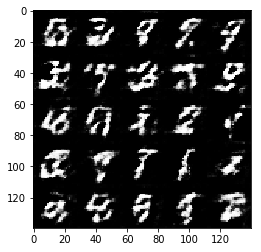

Epoch 0/2 Batch Step 420... Discriminator Loss: 1.7642... Generator Loss: 0.9287
Epoch 0/2 Batch Step 440... Discriminator Loss: 1.5080... Generator Loss: 0.5600
Epoch 0/2 Batch Step 460... Discriminator Loss: 1.6572... Generator Loss: 0.5221
Epoch 0/2 Batch Step 480... Discriminator Loss: 2.2686... Generator Loss: 0.2467
Epoch 0/2 Batch Step 500... Discriminator Loss: 1.6801... Generator Loss: 0.4530
Epoch 0/2 Batch Step 520... Discriminator Loss: 2.2166... Generator Loss: 0.2363
Epoch 0/2 Batch Step 540... Discriminator Loss: 1.7562... Generator Loss: 0.4129
Epoch 0/2 Batch Step 560... Discriminator Loss: 1.2892... Generator Loss: 0.7875
Epoch 0/2 Batch Step 580... Discriminator Loss: 1.6364... Generator Loss: 0.8374
Epoch 0/2 Batch Step 600... Discriminator Loss: 1.6547... Generator Loss: 1.0234


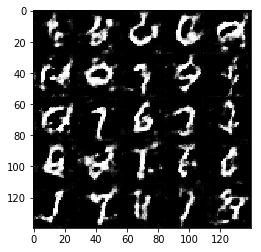

Epoch 0/2 Batch Step 620... Discriminator Loss: 1.5801... Generator Loss: 0.4034
Epoch 0/2 Batch Step 640... Discriminator Loss: 1.3477... Generator Loss: 0.6178
Epoch 0/2 Batch Step 660... Discriminator Loss: 1.9074... Generator Loss: 0.3600
Epoch 0/2 Batch Step 680... Discriminator Loss: 1.6889... Generator Loss: 1.4073
Epoch 0/2 Batch Step 700... Discriminator Loss: 2.9333... Generator Loss: 0.0970
Epoch 0/2 Batch Step 720... Discriminator Loss: 2.2238... Generator Loss: 0.2838
Epoch 0/2 Batch Step 740... Discriminator Loss: 1.2211... Generator Loss: 0.8497
Epoch 0/2 Batch Step 760... Discriminator Loss: 1.9141... Generator Loss: 0.2833
Epoch 0/2 Batch Step 780... Discriminator Loss: 1.7975... Generator Loss: 0.3293
Epoch 0/2 Batch Step 800... Discriminator Loss: 1.1849... Generator Loss: 1.1504


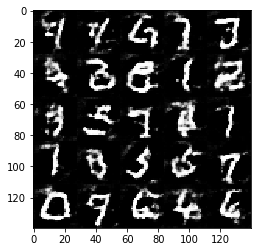

Epoch 0/2 Batch Step 820... Discriminator Loss: 1.1587... Generator Loss: 1.6518
Epoch 0/2 Batch Step 840... Discriminator Loss: 1.3409... Generator Loss: 1.4617
Epoch 0/2 Batch Step 860... Discriminator Loss: 1.0608... Generator Loss: 1.1901
Epoch 0/2 Batch Step 880... Discriminator Loss: 1.6069... Generator Loss: 0.9247
Epoch 0/2 Batch Step 900... Discriminator Loss: 2.0956... Generator Loss: 0.2123
Epoch 0/2 Batch Step 920... Discriminator Loss: 1.7154... Generator Loss: 0.3929
Epoch 0/2 Batch Step 940... Discriminator Loss: 1.4187... Generator Loss: 0.8075
Epoch 0/2 Batch Step 960... Discriminator Loss: 1.5415... Generator Loss: 0.5583
Epoch 0/2 Batch Step 980... Discriminator Loss: 1.8664... Generator Loss: 0.3332
Epoch 0/2 Batch Step 1000... Discriminator Loss: 1.3550... Generator Loss: 0.8427


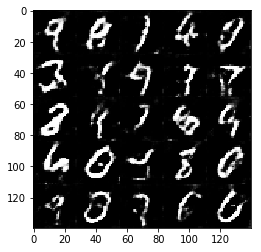

Epoch 0/2 Batch Step 1020... Discriminator Loss: 1.3271... Generator Loss: 1.0402
Epoch 0/2 Batch Step 1040... Discriminator Loss: 1.3732... Generator Loss: 0.5336
Epoch 0/2 Batch Step 1060... Discriminator Loss: 1.1016... Generator Loss: 0.8175
Epoch 0/2 Batch Step 1080... Discriminator Loss: 2.0533... Generator Loss: 0.2615
Epoch 0/2 Batch Step 1100... Discriminator Loss: 1.9227... Generator Loss: 0.3274
Epoch 0/2 Batch Step 1120... Discriminator Loss: 1.5643... Generator Loss: 0.4504
Epoch 0/2 Batch Step 1140... Discriminator Loss: 1.0978... Generator Loss: 0.9943
Epoch 0/2 Batch Step 1160... Discriminator Loss: 1.4019... Generator Loss: 0.5789
Epoch 0/2 Batch Step 1180... Discriminator Loss: 1.8073... Generator Loss: 0.3390
Epoch 0/2 Batch Step 1200... Discriminator Loss: 2.1452... Generator Loss: 0.2370


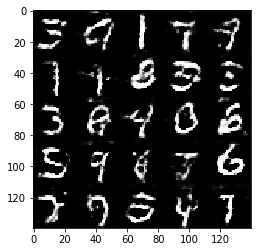

Epoch 0/2 Batch Step 1220... Discriminator Loss: 1.4981... Generator Loss: 0.5674
Epoch 0/2 Batch Step 1240... Discriminator Loss: 1.2274... Generator Loss: 0.6158
Epoch 0/2 Batch Step 1260... Discriminator Loss: 1.5995... Generator Loss: 0.3758
Epoch 0/2 Batch Step 1280... Discriminator Loss: 1.3061... Generator Loss: 0.5530
Epoch 0/2 Batch Step 1300... Discriminator Loss: 2.6116... Generator Loss: 0.1585
Epoch 0/2 Batch Step 1320... Discriminator Loss: 1.4234... Generator Loss: 0.4713
Epoch 0/2 Batch Step 1340... Discriminator Loss: 1.4331... Generator Loss: 0.4440
Epoch 0/2 Batch Step 1360... Discriminator Loss: 1.6262... Generator Loss: 0.4559
Epoch 0/2 Batch Step 1380... Discriminator Loss: 1.2122... Generator Loss: 0.6518
Epoch 0/2 Batch Step 1400... Discriminator Loss: 1.3764... Generator Loss: 0.5406


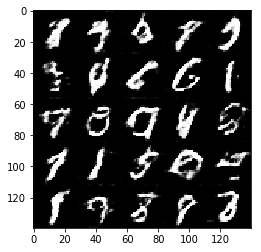

Epoch 0/2 Batch Step 1420... Discriminator Loss: 1.2728... Generator Loss: 0.6144
Epoch 0/2 Batch Step 1440... Discriminator Loss: 1.1541... Generator Loss: 0.7781
Epoch 0/2 Batch Step 1460... Discriminator Loss: 1.0264... Generator Loss: 0.8675
Epoch 0/2 Batch Step 1480... Discriminator Loss: 2.5515... Generator Loss: 0.1520
Epoch 0/2 Batch Step 1500... Discriminator Loss: 1.0060... Generator Loss: 0.8999
Epoch 0/2 Batch Step 1520... Discriminator Loss: 2.4139... Generator Loss: 0.2697
Epoch 0/2 Batch Step 1540... Discriminator Loss: 1.1137... Generator Loss: 0.8933
Epoch 0/2 Batch Step 1560... Discriminator Loss: 2.0605... Generator Loss: 0.2757
Epoch 0/2 Batch Step 1580... Discriminator Loss: 0.9242... Generator Loss: 1.0296
Epoch 0/2 Batch Step 1600... Discriminator Loss: 1.0250... Generator Loss: 0.9688


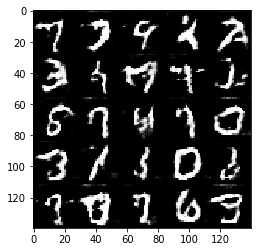

Epoch 0/2 Batch Step 1620... Discriminator Loss: 1.2795... Generator Loss: 0.6589
Epoch 0/2 Batch Step 1640... Discriminator Loss: 0.8743... Generator Loss: 1.1804
Epoch 0/2 Batch Step 1660... Discriminator Loss: 1.5824... Generator Loss: 0.4189
Epoch 0/2 Batch Step 1680... Discriminator Loss: 1.3229... Generator Loss: 0.6280
Epoch 0/2 Batch Step 1700... Discriminator Loss: 1.4831... Generator Loss: 0.4481
Epoch 0/2 Batch Step 1720... Discriminator Loss: 0.9899... Generator Loss: 1.0758
Epoch 0/2 Batch Step 1740... Discriminator Loss: 1.0507... Generator Loss: 1.5791
Epoch 0/2 Batch Step 1760... Discriminator Loss: 2.1544... Generator Loss: 0.2005
Epoch 0/2 Batch Step 1780... Discriminator Loss: 1.1108... Generator Loss: 0.8365
Epoch 0/2 Batch Step 1800... Discriminator Loss: 1.3514... Generator Loss: 0.5717


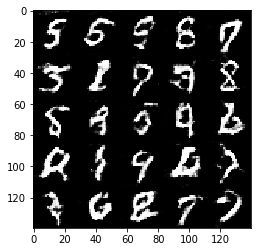

Epoch 0/2 Batch Step 1820... Discriminator Loss: 1.5159... Generator Loss: 0.5687
Epoch 0/2 Batch Step 1840... Discriminator Loss: 2.4099... Generator Loss: 0.3180
Epoch 0/2 Batch Step 1860... Discriminator Loss: 1.9910... Generator Loss: 0.2602
Epoch 0/2 Batch Step 1880... Discriminator Loss: 1.2646... Generator Loss: 0.7264
Epoch 0/2 Batch Step 1900... Discriminator Loss: 1.2221... Generator Loss: 0.8829
Epoch 0/2 Batch Step 1920... Discriminator Loss: 0.8550... Generator Loss: 1.1290
Epoch 0/2 Batch Step 1940... Discriminator Loss: 1.6568... Generator Loss: 0.4512
Epoch 0/2 Batch Step 1960... Discriminator Loss: 1.0338... Generator Loss: 0.9654
Epoch 0/2 Batch Step 1980... Discriminator Loss: 0.9257... Generator Loss: 1.0399
Epoch 0/2 Batch Step 2000... Discriminator Loss: 0.7862... Generator Loss: 1.2951


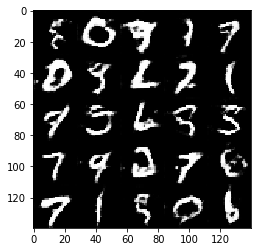

Epoch 0/2 Batch Step 2020... Discriminator Loss: 0.7800... Generator Loss: 1.1761
Epoch 0/2 Batch Step 2040... Discriminator Loss: 1.0819... Generator Loss: 2.5234
Epoch 0/2 Batch Step 2060... Discriminator Loss: 0.8068... Generator Loss: 1.2071
Epoch 0/2 Batch Step 2080... Discriminator Loss: 1.2021... Generator Loss: 0.8774
Epoch 0/2 Batch Step 2100... Discriminator Loss: 1.0065... Generator Loss: 0.8708
Epoch 0/2 Batch Step 2120... Discriminator Loss: 0.8033... Generator Loss: 1.2378
Epoch 0/2 Batch Step 2140... Discriminator Loss: 0.6843... Generator Loss: 1.4075
Epoch 0/2 Batch Step 2160... Discriminator Loss: 0.7937... Generator Loss: 1.2627
Epoch 0/2 Batch Step 2180... Discriminator Loss: 0.9196... Generator Loss: 0.9202
Epoch 0/2 Batch Step 2200... Discriminator Loss: 1.3773... Generator Loss: 0.7140


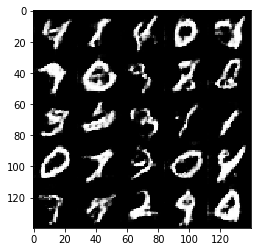

Epoch 0/2 Batch Step 2220... Discriminator Loss: 1.4069... Generator Loss: 0.5220
Epoch 0/2 Batch Step 2240... Discriminator Loss: 1.7142... Generator Loss: 0.3393
Epoch 0/2 Batch Step 2260... Discriminator Loss: 0.5806... Generator Loss: 2.1079
Epoch 0/2 Batch Step 2280... Discriminator Loss: 0.8357... Generator Loss: 1.6429
Epoch 0/2 Batch Step 2300... Discriminator Loss: 1.2715... Generator Loss: 0.7416
Epoch 0/2 Batch Step 2320... Discriminator Loss: 0.5920... Generator Loss: 1.9752
Epoch 0/2 Batch Step 2340... Discriminator Loss: 0.9622... Generator Loss: 0.9561
Epoch 0/2 Batch Step 2360... Discriminator Loss: 0.8918... Generator Loss: 1.9805
Epoch 0/2 Batch Step 2380... Discriminator Loss: 0.7225... Generator Loss: 1.3265
Epoch 0/2 Batch Step 2400... Discriminator Loss: 0.7857... Generator Loss: 1.3324


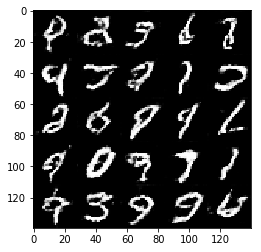

Epoch 0/2 Batch Step 2420... Discriminator Loss: 0.8568... Generator Loss: 1.1109
Epoch 0/2 Batch Step 2440... Discriminator Loss: 1.3654... Generator Loss: 0.6597
Epoch 0/2 Batch Step 2460... Discriminator Loss: 1.2968... Generator Loss: 0.7208
Epoch 0/2 Batch Step 2480... Discriminator Loss: 0.5111... Generator Loss: 2.0557
Epoch 0/2 Batch Step 2500... Discriminator Loss: 0.9024... Generator Loss: 1.1058
Epoch 0/2 Batch Step 2520... Discriminator Loss: 0.6118... Generator Loss: 1.7286
Epoch 0/2 Batch Step 2540... Discriminator Loss: 1.2847... Generator Loss: 0.7690
Epoch 0/2 Batch Step 2560... Discriminator Loss: 0.9172... Generator Loss: 1.8289
Epoch 0/2 Batch Step 2580... Discriminator Loss: 1.6137... Generator Loss: 0.4152
Epoch 0/2 Batch Step 2600... Discriminator Loss: 0.7861... Generator Loss: 1.8066


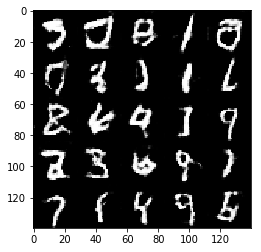

Epoch 0/2 Batch Step 2620... Discriminator Loss: 0.7504... Generator Loss: 1.4588
Epoch 0/2 Batch Step 2640... Discriminator Loss: 1.1661... Generator Loss: 0.7864
Epoch 0/2 Batch Step 2660... Discriminator Loss: 0.7986... Generator Loss: 1.1225
Epoch 0/2 Batch Step 2680... Discriminator Loss: 2.9852... Generator Loss: 0.1318
Epoch 0/2 Batch Step 2700... Discriminator Loss: 1.4648... Generator Loss: 3.3473
Epoch 0/2 Batch Step 2720... Discriminator Loss: 1.6880... Generator Loss: 0.3655
Epoch 0/2 Batch Step 2740... Discriminator Loss: 0.6846... Generator Loss: 2.0453
Epoch 0/2 Batch Step 2760... Discriminator Loss: 1.6538... Generator Loss: 0.3877
Epoch 0/2 Batch Step 2780... Discriminator Loss: 0.6273... Generator Loss: 1.5756
Epoch 0/2 Batch Step 2800... Discriminator Loss: 0.9597... Generator Loss: 0.8398


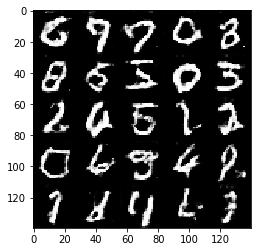

Epoch 0/2 Batch Step 2820... Discriminator Loss: 1.3350... Generator Loss: 0.6616
Epoch 0/2 Batch Step 2840... Discriminator Loss: 1.7938... Generator Loss: 0.4476
Epoch 0/2 Batch Step 2860... Discriminator Loss: 0.7614... Generator Loss: 1.3260
Epoch 0/2 Batch Step 2880... Discriminator Loss: 0.6748... Generator Loss: 1.3347
Epoch 0/2 Batch Step 2900... Discriminator Loss: 0.5084... Generator Loss: 2.2640
Epoch 0/2 Batch Step 2920... Discriminator Loss: 0.6405... Generator Loss: 1.5895
Epoch 0/2 Batch Step 2940... Discriminator Loss: 0.6431... Generator Loss: 1.7372
Epoch 0/2 Batch Step 2960... Discriminator Loss: 0.6681... Generator Loss: 1.8278
Epoch 0/2 Batch Step 2980... Discriminator Loss: 0.8022... Generator Loss: 1.0899
Epoch 0/2 Batch Step 3000... Discriminator Loss: 2.2270... Generator Loss: 0.3948


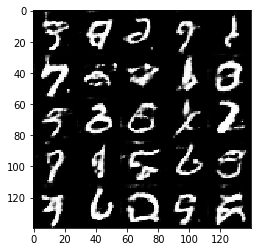

Epoch 0/2 Batch Step 3020... Discriminator Loss: 1.0736... Generator Loss: 0.8190
Epoch 0/2 Batch Step 3040... Discriminator Loss: 0.7032... Generator Loss: 1.4219
Epoch 0/2 Batch Step 3060... Discriminator Loss: 0.7672... Generator Loss: 1.4514
Epoch 0/2 Batch Step 3080... Discriminator Loss: 0.6848... Generator Loss: 2.3852
Epoch 0/2 Batch Step 3100... Discriminator Loss: 1.9389... Generator Loss: 0.4799
Epoch 0/2 Batch Step 3120... Discriminator Loss: 1.4879... Generator Loss: 0.5755
Epoch 0/2 Batch Step 3140... Discriminator Loss: 2.3000... Generator Loss: 0.2601
Epoch 0/2 Batch Step 3160... Discriminator Loss: 0.7910... Generator Loss: 1.1652
Epoch 0/2 Batch Step 3180... Discriminator Loss: 0.9105... Generator Loss: 3.1503
Epoch 0/2 Batch Step 3200... Discriminator Loss: 1.6057... Generator Loss: 0.5449


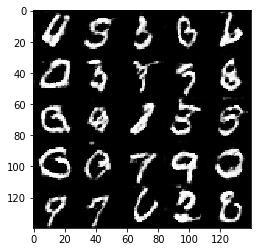

Epoch 0/2 Batch Step 3220... Discriminator Loss: 0.7437... Generator Loss: 1.3390
Epoch 0/2 Batch Step 3240... Discriminator Loss: 1.1523... Generator Loss: 0.7261
Epoch 0/2 Batch Step 3260... Discriminator Loss: 0.5978... Generator Loss: 1.8239
Epoch 0/2 Batch Step 3280... Discriminator Loss: 0.5605... Generator Loss: 1.9580
Epoch 0/2 Batch Step 3300... Discriminator Loss: 0.6682... Generator Loss: 1.6019
Epoch 0/2 Batch Step 3320... Discriminator Loss: 1.2104... Generator Loss: 0.8107
Epoch 0/2 Batch Step 3340... Discriminator Loss: 0.9030... Generator Loss: 1.1455
Epoch 0/2 Batch Step 3360... Discriminator Loss: 0.6222... Generator Loss: 2.0360
Epoch 0/2 Batch Step 3380... Discriminator Loss: 0.6467... Generator Loss: 1.7155
Epoch 0/2 Batch Step 3400... Discriminator Loss: 0.5307... Generator Loss: 2.0466


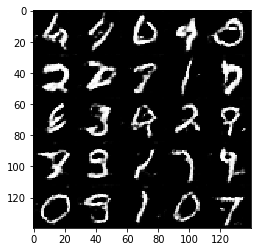

Epoch 0/2 Batch Step 3420... Discriminator Loss: 0.5883... Generator Loss: 1.9123
Epoch 0/2 Batch Step 3440... Discriminator Loss: 0.5858... Generator Loss: 1.9554
Epoch 0/2 Batch Step 3460... Discriminator Loss: 0.9759... Generator Loss: 0.9058
Epoch 0/2 Batch Step 3480... Discriminator Loss: 1.0440... Generator Loss: 0.9443
Epoch 0/2 Batch Step 3500... Discriminator Loss: 0.5998... Generator Loss: 1.8750
Epoch 0/2 Batch Step 3520... Discriminator Loss: 1.6766... Generator Loss: 2.6075
Epoch 0/2 Batch Step 3540... Discriminator Loss: 2.1016... Generator Loss: 0.2793
Epoch 0/2 Batch Step 3560... Discriminator Loss: 0.8137... Generator Loss: 1.1587
Epoch 0/2 Batch Step 3580... Discriminator Loss: 0.9034... Generator Loss: 1.0264
Epoch 0/2 Batch Step 3600... Discriminator Loss: 0.4911... Generator Loss: 2.5749


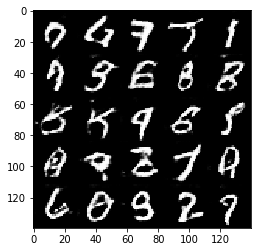

Epoch 0/2 Batch Step 3620... Discriminator Loss: 0.8456... Generator Loss: 1.3719
Epoch 0/2 Batch Step 3640... Discriminator Loss: 0.6664... Generator Loss: 2.2100
Epoch 0/2 Batch Step 3660... Discriminator Loss: 1.6241... Generator Loss: 0.5496
Epoch 0/2 Batch Step 3680... Discriminator Loss: 0.8938... Generator Loss: 1.0742
Epoch 0/2 Batch Step 3700... Discriminator Loss: 0.6442... Generator Loss: 2.0041
Epoch 0/2 Batch Step 3720... Discriminator Loss: 0.8772... Generator Loss: 1.1543
Epoch 0/2 Batch Step 3740... Discriminator Loss: 0.6364... Generator Loss: 1.5669
Epoch 1/2 Batch Step 3760... Discriminator Loss: 0.9772... Generator Loss: 0.9589
Epoch 1/2 Batch Step 3780... Discriminator Loss: 0.8506... Generator Loss: 1.3032
Epoch 1/2 Batch Step 3800... Discriminator Loss: 1.2475... Generator Loss: 0.7640


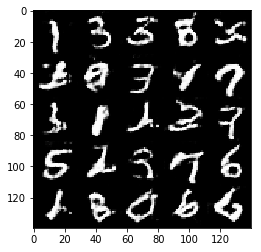

Epoch 1/2 Batch Step 3820... Discriminator Loss: 0.7169... Generator Loss: 1.5115
Epoch 1/2 Batch Step 3840... Discriminator Loss: 0.7054... Generator Loss: 1.4602
Epoch 1/2 Batch Step 3860... Discriminator Loss: 1.1093... Generator Loss: 0.7955
Epoch 1/2 Batch Step 3880... Discriminator Loss: 0.6596... Generator Loss: 1.6902
Epoch 1/2 Batch Step 3900... Discriminator Loss: 0.6686... Generator Loss: 1.8235
Epoch 1/2 Batch Step 3920... Discriminator Loss: 0.9233... Generator Loss: 0.9225
Epoch 1/2 Batch Step 3940... Discriminator Loss: 1.2300... Generator Loss: 0.7005
Epoch 1/2 Batch Step 3960... Discriminator Loss: 0.6773... Generator Loss: 1.6990
Epoch 1/2 Batch Step 3980... Discriminator Loss: 0.7626... Generator Loss: 1.3046
Epoch 1/2 Batch Step 4000... Discriminator Loss: 0.5732... Generator Loss: 1.8107


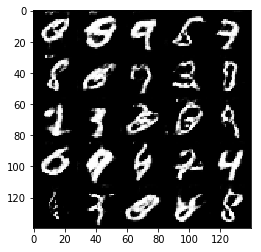

Epoch 1/2 Batch Step 4020... Discriminator Loss: 0.7275... Generator Loss: 1.3432
Epoch 1/2 Batch Step 4040... Discriminator Loss: 0.6422... Generator Loss: 1.6908
Epoch 1/2 Batch Step 4060... Discriminator Loss: 0.8403... Generator Loss: 1.7958
Epoch 1/2 Batch Step 4080... Discriminator Loss: 0.6720... Generator Loss: 1.4891
Epoch 1/2 Batch Step 4100... Discriminator Loss: 2.1694... Generator Loss: 0.4443
Epoch 1/2 Batch Step 4120... Discriminator Loss: 1.2279... Generator Loss: 0.6787
Epoch 1/2 Batch Step 4140... Discriminator Loss: 0.7182... Generator Loss: 1.6276
Epoch 1/2 Batch Step 4160... Discriminator Loss: 0.8256... Generator Loss: 2.6886
Epoch 1/2 Batch Step 4180... Discriminator Loss: 0.5203... Generator Loss: 1.9839
Epoch 1/2 Batch Step 4200... Discriminator Loss: 0.6409... Generator Loss: 1.5190


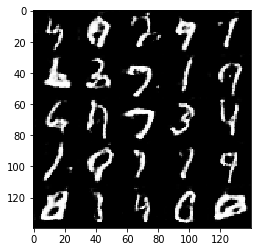

Epoch 1/2 Batch Step 4220... Discriminator Loss: 0.9306... Generator Loss: 0.9498
Epoch 1/2 Batch Step 4240... Discriminator Loss: 1.3440... Generator Loss: 0.6910
Epoch 1/2 Batch Step 4260... Discriminator Loss: 0.5808... Generator Loss: 1.7117
Epoch 1/2 Batch Step 4280... Discriminator Loss: 0.6362... Generator Loss: 2.0828
Epoch 1/2 Batch Step 4300... Discriminator Loss: 1.0401... Generator Loss: 0.8924
Epoch 1/2 Batch Step 4320... Discriminator Loss: 0.8135... Generator Loss: 1.1964
Epoch 1/2 Batch Step 4340... Discriminator Loss: 0.9604... Generator Loss: 2.7994
Epoch 1/2 Batch Step 4360... Discriminator Loss: 0.6784... Generator Loss: 1.5211
Epoch 1/2 Batch Step 4380... Discriminator Loss: 0.5463... Generator Loss: 1.8792
Epoch 1/2 Batch Step 4400... Discriminator Loss: 0.7166... Generator Loss: 2.7689


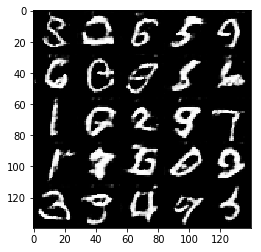

Epoch 1/2 Batch Step 4420... Discriminator Loss: 0.7036... Generator Loss: 1.4509
Epoch 1/2 Batch Step 4440... Discriminator Loss: 0.7925... Generator Loss: 1.2698
Epoch 1/2 Batch Step 4460... Discriminator Loss: 0.6290... Generator Loss: 1.6341
Epoch 1/2 Batch Step 4480... Discriminator Loss: 0.7677... Generator Loss: 1.2614
Epoch 1/2 Batch Step 4500... Discriminator Loss: 1.3917... Generator Loss: 0.6813
Epoch 1/2 Batch Step 4520... Discriminator Loss: 0.7647... Generator Loss: 1.2799
Epoch 1/2 Batch Step 4540... Discriminator Loss: 0.8013... Generator Loss: 1.2038
Epoch 1/2 Batch Step 4560... Discriminator Loss: 0.5566... Generator Loss: 2.0667
Epoch 1/2 Batch Step 4580... Discriminator Loss: 0.9852... Generator Loss: 0.9048
Epoch 1/2 Batch Step 4600... Discriminator Loss: 1.0159... Generator Loss: 1.3139


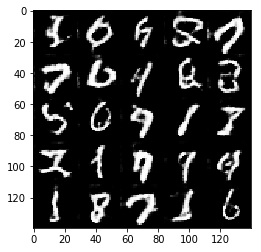

Epoch 1/2 Batch Step 4620... Discriminator Loss: 0.8386... Generator Loss: 1.2776
Epoch 1/2 Batch Step 4640... Discriminator Loss: 0.7704... Generator Loss: 1.3025
Epoch 1/2 Batch Step 4660... Discriminator Loss: 0.9485... Generator Loss: 0.9394
Epoch 1/2 Batch Step 4680... Discriminator Loss: 0.9552... Generator Loss: 1.0783
Epoch 1/2 Batch Step 4700... Discriminator Loss: 0.6526... Generator Loss: 1.5342
Epoch 1/2 Batch Step 4720... Discriminator Loss: 0.6630... Generator Loss: 1.6700
Epoch 1/2 Batch Step 4740... Discriminator Loss: 0.6449... Generator Loss: 1.6378
Epoch 1/2 Batch Step 4760... Discriminator Loss: 0.5856... Generator Loss: 1.8089
Epoch 1/2 Batch Step 4780... Discriminator Loss: 1.9366... Generator Loss: 0.5703
Epoch 1/2 Batch Step 4800... Discriminator Loss: 0.9590... Generator Loss: 0.9140


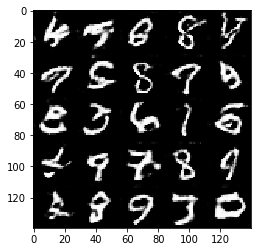

Epoch 1/2 Batch Step 4820... Discriminator Loss: 0.9791... Generator Loss: 3.8762
Epoch 1/2 Batch Step 4840... Discriminator Loss: 1.1137... Generator Loss: 0.7168
Epoch 1/2 Batch Step 4860... Discriminator Loss: 1.3037... Generator Loss: 0.6588
Epoch 1/2 Batch Step 4880... Discriminator Loss: 1.1292... Generator Loss: 0.7874
Epoch 1/2 Batch Step 4900... Discriminator Loss: 1.6466... Generator Loss: 0.4653
Epoch 1/2 Batch Step 4920... Discriminator Loss: 1.2139... Generator Loss: 0.8257
Epoch 1/2 Batch Step 4940... Discriminator Loss: 0.8521... Generator Loss: 2.9689
Epoch 1/2 Batch Step 4960... Discriminator Loss: 0.9477... Generator Loss: 1.0253
Epoch 1/2 Batch Step 4980... Discriminator Loss: 0.5388... Generator Loss: 2.0489
Epoch 1/2 Batch Step 5000... Discriminator Loss: 0.6483... Generator Loss: 2.0732


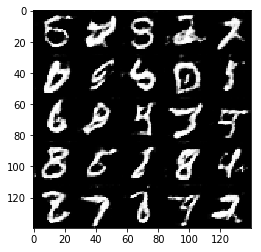

Epoch 1/2 Batch Step 5020... Discriminator Loss: 0.6853... Generator Loss: 1.4749
Epoch 1/2 Batch Step 5040... Discriminator Loss: 0.5027... Generator Loss: 2.2487
Epoch 1/2 Batch Step 5060... Discriminator Loss: 1.0132... Generator Loss: 0.8468
Epoch 1/2 Batch Step 5080... Discriminator Loss: 0.6941... Generator Loss: 1.6897
Epoch 1/2 Batch Step 5100... Discriminator Loss: 0.9789... Generator Loss: 0.9517
Epoch 1/2 Batch Step 5120... Discriminator Loss: 1.4227... Generator Loss: 0.5317
Epoch 1/2 Batch Step 5140... Discriminator Loss: 0.6844... Generator Loss: 1.4991
Epoch 1/2 Batch Step 5160... Discriminator Loss: 0.5938... Generator Loss: 1.8973
Epoch 1/2 Batch Step 5180... Discriminator Loss: 0.8686... Generator Loss: 1.1529
Epoch 1/2 Batch Step 5200... Discriminator Loss: 0.5982... Generator Loss: 1.7963


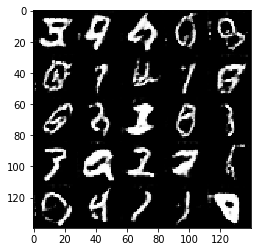

Epoch 1/2 Batch Step 5220... Discriminator Loss: 1.0708... Generator Loss: 0.8222
Epoch 1/2 Batch Step 5240... Discriminator Loss: 1.3002... Generator Loss: 0.7210
Epoch 1/2 Batch Step 5260... Discriminator Loss: 0.6120... Generator Loss: 1.6768
Epoch 1/2 Batch Step 5280... Discriminator Loss: 1.3686... Generator Loss: 0.5346
Epoch 1/2 Batch Step 5300... Discriminator Loss: 0.7025... Generator Loss: 1.2704
Epoch 1/2 Batch Step 5320... Discriminator Loss: 1.0720... Generator Loss: 0.7725
Epoch 1/2 Batch Step 5340... Discriminator Loss: 0.7940... Generator Loss: 1.3145
Epoch 1/2 Batch Step 5360... Discriminator Loss: 0.8441... Generator Loss: 1.1389
Epoch 1/2 Batch Step 5380... Discriminator Loss: 0.5120... Generator Loss: 2.0085
Epoch 1/2 Batch Step 5400... Discriminator Loss: 1.1899... Generator Loss: 0.6858


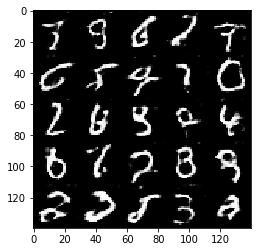

Epoch 1/2 Batch Step 5420... Discriminator Loss: 0.4546... Generator Loss: 2.6961
Epoch 1/2 Batch Step 5440... Discriminator Loss: 0.8071... Generator Loss: 1.2377
Epoch 1/2 Batch Step 5460... Discriminator Loss: 1.5499... Generator Loss: 2.9703
Epoch 1/2 Batch Step 5480... Discriminator Loss: 1.9673... Generator Loss: 0.2879
Epoch 1/2 Batch Step 5500... Discriminator Loss: 1.0691... Generator Loss: 0.7672
Epoch 1/2 Batch Step 5520... Discriminator Loss: 0.6372... Generator Loss: 1.6141
Epoch 1/2 Batch Step 5540... Discriminator Loss: 0.6613... Generator Loss: 1.5579
Epoch 1/2 Batch Step 5560... Discriminator Loss: 0.6021... Generator Loss: 2.3834
Epoch 1/2 Batch Step 5580... Discriminator Loss: 0.8601... Generator Loss: 1.1719
Epoch 1/2 Batch Step 5600... Discriminator Loss: 1.0233... Generator Loss: 0.8938


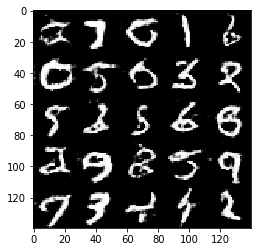

Epoch 1/2 Batch Step 5620... Discriminator Loss: 0.7597... Generator Loss: 2.9540
Epoch 1/2 Batch Step 5640... Discriminator Loss: 1.9507... Generator Loss: 6.1957
Epoch 1/2 Batch Step 5660... Discriminator Loss: 0.6258... Generator Loss: 1.6909
Epoch 1/2 Batch Step 5680... Discriminator Loss: 1.3609... Generator Loss: 0.5968
Epoch 1/2 Batch Step 5700... Discriminator Loss: 0.9593... Generator Loss: 1.0935
Epoch 1/2 Batch Step 5720... Discriminator Loss: 0.7214... Generator Loss: 1.5454
Epoch 1/2 Batch Step 5740... Discriminator Loss: 0.9978... Generator Loss: 1.1221
Epoch 1/2 Batch Step 5760... Discriminator Loss: 0.9453... Generator Loss: 1.1422
Epoch 1/2 Batch Step 5780... Discriminator Loss: 0.7029... Generator Loss: 1.4469
Epoch 1/2 Batch Step 5800... Discriminator Loss: 1.4992... Generator Loss: 0.8059


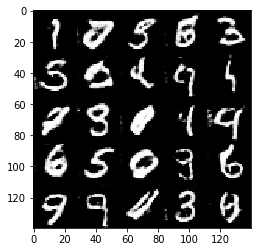

Epoch 1/2 Batch Step 5820... Discriminator Loss: 0.7848... Generator Loss: 1.2609
Epoch 1/2 Batch Step 5840... Discriminator Loss: 0.6606... Generator Loss: 1.4819
Epoch 1/2 Batch Step 5860... Discriminator Loss: 0.9151... Generator Loss: 1.1468
Epoch 1/2 Batch Step 5880... Discriminator Loss: 0.6118... Generator Loss: 1.7085
Epoch 1/2 Batch Step 5900... Discriminator Loss: 0.8145... Generator Loss: 1.1184
Epoch 1/2 Batch Step 5920... Discriminator Loss: 0.6760... Generator Loss: 1.4851
Epoch 1/2 Batch Step 5940... Discriminator Loss: 0.5919... Generator Loss: 1.8605
Epoch 1/2 Batch Step 5960... Discriminator Loss: 0.7875... Generator Loss: 1.3984
Epoch 1/2 Batch Step 5980... Discriminator Loss: 0.6529... Generator Loss: 1.6212
Epoch 1/2 Batch Step 6000... Discriminator Loss: 0.9380... Generator Loss: 1.0309


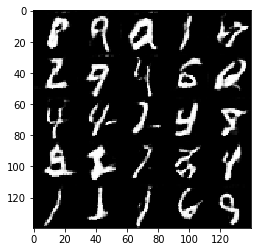

Epoch 1/2 Batch Step 6020... Discriminator Loss: 1.0606... Generator Loss: 0.8726
Epoch 1/2 Batch Step 6040... Discriminator Loss: 0.5610... Generator Loss: 2.9188
Epoch 1/2 Batch Step 6060... Discriminator Loss: 0.6040... Generator Loss: 1.7903
Epoch 1/2 Batch Step 6080... Discriminator Loss: 0.7759... Generator Loss: 1.5641
Epoch 1/2 Batch Step 6100... Discriminator Loss: 0.6540... Generator Loss: 1.3962
Epoch 1/2 Batch Step 6120... Discriminator Loss: 0.4535... Generator Loss: 2.5064
Epoch 1/2 Batch Step 6140... Discriminator Loss: 0.4610... Generator Loss: 2.3440
Epoch 1/2 Batch Step 6160... Discriminator Loss: 0.5319... Generator Loss: 2.2888
Epoch 1/2 Batch Step 6180... Discriminator Loss: 0.9242... Generator Loss: 2.0310
Epoch 1/2 Batch Step 6200... Discriminator Loss: 0.6938... Generator Loss: 1.5001


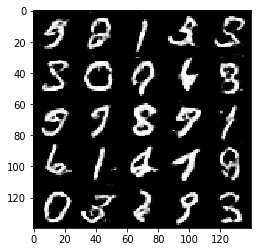

Epoch 1/2 Batch Step 6220... Discriminator Loss: 0.6233... Generator Loss: 1.8833
Epoch 1/2 Batch Step 6240... Discriminator Loss: 0.6298... Generator Loss: 1.7049
Epoch 1/2 Batch Step 6260... Discriminator Loss: 0.9332... Generator Loss: 0.9333
Epoch 1/2 Batch Step 6280... Discriminator Loss: 0.8607... Generator Loss: 1.1127
Epoch 1/2 Batch Step 6300... Discriminator Loss: 1.1901... Generator Loss: 0.9133
Epoch 1/2 Batch Step 6320... Discriminator Loss: 0.7562... Generator Loss: 1.2564
Epoch 1/2 Batch Step 6340... Discriminator Loss: 0.9497... Generator Loss: 1.2184
Epoch 1/2 Batch Step 6360... Discriminator Loss: 0.5704... Generator Loss: 1.8448
Epoch 1/2 Batch Step 6380... Discriminator Loss: 0.7229... Generator Loss: 1.3486
Epoch 1/2 Batch Step 6400... Discriminator Loss: 0.6132... Generator Loss: 2.0537


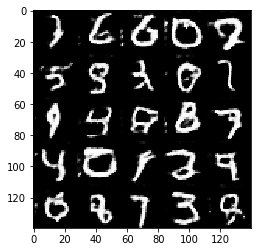

Epoch 1/2 Batch Step 6420... Discriminator Loss: 0.9323... Generator Loss: 1.1590
Epoch 1/2 Batch Step 6440... Discriminator Loss: 0.8789... Generator Loss: 1.1782
Epoch 1/2 Batch Step 6460... Discriminator Loss: 1.1324... Generator Loss: 3.2800
Epoch 1/2 Batch Step 6480... Discriminator Loss: 0.6405... Generator Loss: 1.7322
Epoch 1/2 Batch Step 6500... Discriminator Loss: 0.6774... Generator Loss: 1.6001
Epoch 1/2 Batch Step 6520... Discriminator Loss: 0.8284... Generator Loss: 1.2901
Epoch 1/2 Batch Step 6540... Discriminator Loss: 0.6706... Generator Loss: 1.7885
Epoch 1/2 Batch Step 6560... Discriminator Loss: 0.8434... Generator Loss: 1.2336
Epoch 1/2 Batch Step 6580... Discriminator Loss: 1.2502... Generator Loss: 0.7689
Epoch 1/2 Batch Step 6600... Discriminator Loss: 0.4601... Generator Loss: 2.4986


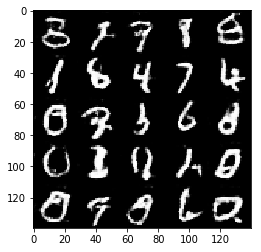

Epoch 1/2 Batch Step 6620... Discriminator Loss: 0.7408... Generator Loss: 1.3447
Epoch 1/2 Batch Step 6640... Discriminator Loss: 0.3635... Generator Loss: 4.4857
Epoch 1/2 Batch Step 6660... Discriminator Loss: 0.4525... Generator Loss: 2.6140
Epoch 1/2 Batch Step 6680... Discriminator Loss: 0.5894... Generator Loss: 1.8114
Epoch 1/2 Batch Step 6700... Discriminator Loss: 0.7757... Generator Loss: 1.3165
Epoch 1/2 Batch Step 6720... Discriminator Loss: 0.4892... Generator Loss: 2.2679
Epoch 1/2 Batch Step 6740... Discriminator Loss: 2.5173... Generator Loss: 0.2133
Epoch 1/2 Batch Step 6760... Discriminator Loss: 0.7064... Generator Loss: 1.4829
Epoch 1/2 Batch Step 6780... Discriminator Loss: 0.4285... Generator Loss: 2.7317
Epoch 1/2 Batch Step 6800... Discriminator Loss: 0.6298... Generator Loss: 1.5305


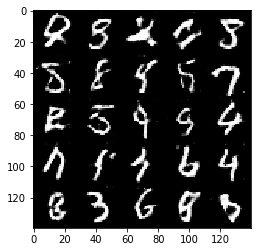

Epoch 1/2 Batch Step 6820... Discriminator Loss: 0.5472... Generator Loss: 1.9242
Epoch 1/2 Batch Step 6840... Discriminator Loss: 0.9169... Generator Loss: 1.0901
Epoch 1/2 Batch Step 6860... Discriminator Loss: 0.9722... Generator Loss: 1.0263
Epoch 1/2 Batch Step 6880... Discriminator Loss: 0.6724... Generator Loss: 2.0672
Epoch 1/2 Batch Step 6900... Discriminator Loss: 0.6029... Generator Loss: 1.6794
Epoch 1/2 Batch Step 6920... Discriminator Loss: 0.9855... Generator Loss: 1.0193
Epoch 1/2 Batch Step 6940... Discriminator Loss: 0.4933... Generator Loss: 2.1975
Epoch 1/2 Batch Step 6960... Discriminator Loss: 0.5953... Generator Loss: 1.5875
Epoch 1/2 Batch Step 6980... Discriminator Loss: 1.2494... Generator Loss: 0.9574
Epoch 1/2 Batch Step 7000... Discriminator Loss: 0.5893... Generator Loss: 1.8003


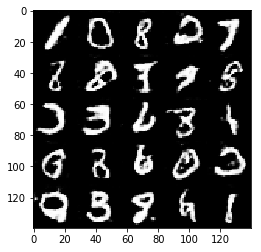

Epoch 1/2 Batch Step 7020... Discriminator Loss: 0.4819... Generator Loss: 2.3796
Epoch 1/2 Batch Step 7040... Discriminator Loss: 0.6977... Generator Loss: 1.5762
Epoch 1/2 Batch Step 7060... Discriminator Loss: 0.6564... Generator Loss: 1.4944
Epoch 1/2 Batch Step 7080... Discriminator Loss: 0.6593... Generator Loss: 1.7944
Epoch 1/2 Batch Step 7100... Discriminator Loss: 0.4742... Generator Loss: 2.6537
Epoch 1/2 Batch Step 7120... Discriminator Loss: 0.5017... Generator Loss: 2.1321
Epoch 1/2 Batch Step 7140... Discriminator Loss: 1.4782... Generator Loss: 0.5616
Epoch 1/2 Batch Step 7160... Discriminator Loss: 1.2860... Generator Loss: 0.6906
Epoch 1/2 Batch Step 7180... Discriminator Loss: 1.9249... Generator Loss: 0.4598
Epoch 1/2 Batch Step 7200... Discriminator Loss: 0.9090... Generator Loss: 1.1217


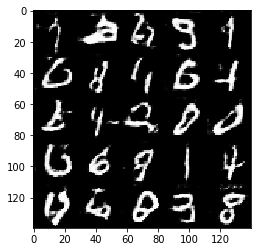

Epoch 1/2 Batch Step 7220... Discriminator Loss: 0.5620... Generator Loss: 2.7404
Epoch 1/2 Batch Step 7240... Discriminator Loss: 0.9239... Generator Loss: 1.0022
Epoch 1/2 Batch Step 7260... Discriminator Loss: 0.5205... Generator Loss: 2.1782
Epoch 1/2 Batch Step 7280... Discriminator Loss: 1.6457... Generator Loss: 0.4692
Epoch 1/2 Batch Step 7300... Discriminator Loss: 0.6077... Generator Loss: 1.9228
Epoch 1/2 Batch Step 7320... Discriminator Loss: 1.1255... Generator Loss: 0.6711
Epoch 1/2 Batch Step 7340... Discriminator Loss: 0.5692... Generator Loss: 1.7826
Epoch 1/2 Batch Step 7360... Discriminator Loss: 1.2207... Generator Loss: 0.8064
Epoch 1/2 Batch Step 7380... Discriminator Loss: 3.0299... Generator Loss: 0.1048
Epoch 1/2 Batch Step 7400... Discriminator Loss: 0.7391... Generator Loss: 1.4388


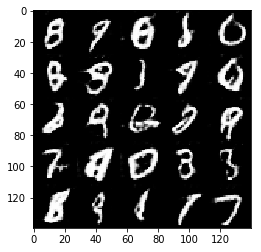

Epoch 1/2 Batch Step 7420... Discriminator Loss: 0.5563... Generator Loss: 2.2107
Epoch 1/2 Batch Step 7440... Discriminator Loss: 0.6356... Generator Loss: 1.6752
Epoch 1/2 Batch Step 7460... Discriminator Loss: 0.9909... Generator Loss: 0.7903
Epoch 1/2 Batch Step 7480... Discriminator Loss: 0.6109... Generator Loss: 1.6187
Epoch 1/2 Batch Step 7500... Discriminator Loss: 0.6219... Generator Loss: 1.8056
Done Training!


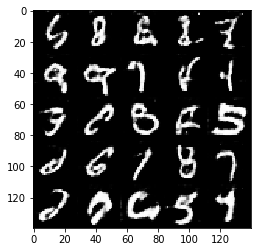

In [16]:
batch_size = 16
z_dim = 1024
learning_rate = 0.0006
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1 Batch Step 20... Discriminator Loss: 1.8874... Generator Loss: 15.1667
Epoch 0/1 Batch Step 40... Discriminator Loss: 1.8901... Generator Loss: 9.1665
Epoch 0/1 Batch Step 60... Discriminator Loss: 0.9047... Generator Loss: 1.0303
Epoch 0/1 Batch Step 80... Discriminator Loss: 0.7131... Generator Loss: 2.5151
Epoch 0/1 Batch Step 100... Discriminator Loss: 0.7164... Generator Loss: 1.4207
Epoch 0/1 Batch Step 120... Discriminator Loss: 7.1309... Generator Loss: 0.0027
Epoch 0/1 Batch Step 140... Discriminator Loss: 0.4455... Generator Loss: 3.1020
Epoch 0/1 Batch Step 160... Discriminator Loss: 1.6442... Generator Loss: 0.4093
Epoch 0/1 Batch Step 180... Discriminator Loss: 2.3144... Generator Loss: 0.2094
Epoch 0/1 Batch Step 200... Discriminator Loss: 0.4935... Generator Loss: 2.2007


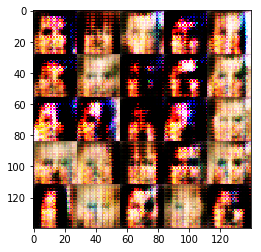

Epoch 0/1 Batch Step 220... Discriminator Loss: 1.9238... Generator Loss: 0.5059
Epoch 0/1 Batch Step 240... Discriminator Loss: 1.4790... Generator Loss: 0.4594
Epoch 0/1 Batch Step 260... Discriminator Loss: 2.3183... Generator Loss: 0.2116
Epoch 0/1 Batch Step 280... Discriminator Loss: 2.0605... Generator Loss: 0.2670
Epoch 0/1 Batch Step 300... Discriminator Loss: 0.9068... Generator Loss: 1.3290
Epoch 0/1 Batch Step 320... Discriminator Loss: 1.0264... Generator Loss: 0.9790
Epoch 0/1 Batch Step 340... Discriminator Loss: 0.6934... Generator Loss: 1.5594
Epoch 0/1 Batch Step 360... Discriminator Loss: 1.6129... Generator Loss: 2.4121
Epoch 0/1 Batch Step 380... Discriminator Loss: 1.3782... Generator Loss: 0.9257
Epoch 0/1 Batch Step 400... Discriminator Loss: 1.3528... Generator Loss: 0.7845


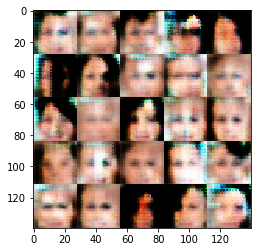

Epoch 0/1 Batch Step 420... Discriminator Loss: 1.2637... Generator Loss: 1.0908
Epoch 0/1 Batch Step 440... Discriminator Loss: 1.3607... Generator Loss: 0.5458
Epoch 0/1 Batch Step 460... Discriminator Loss: 1.2691... Generator Loss: 0.6624
Epoch 0/1 Batch Step 480... Discriminator Loss: 0.4227... Generator Loss: 3.3801
Epoch 0/1 Batch Step 500... Discriminator Loss: 1.2143... Generator Loss: 1.3402
Epoch 0/1 Batch Step 520... Discriminator Loss: 1.0880... Generator Loss: 1.3459
Epoch 0/1 Batch Step 540... Discriminator Loss: 0.7019... Generator Loss: 1.3895
Epoch 0/1 Batch Step 560... Discriminator Loss: 0.6567... Generator Loss: 3.0893
Epoch 0/1 Batch Step 580... Discriminator Loss: 0.3866... Generator Loss: 3.6550
Epoch 0/1 Batch Step 600... Discriminator Loss: 0.3653... Generator Loss: 4.0506


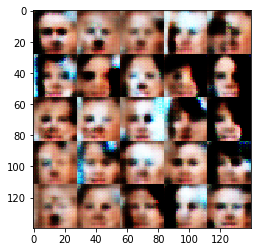

Epoch 0/1 Batch Step 620... Discriminator Loss: 1.6901... Generator Loss: 0.3475
Epoch 0/1 Batch Step 640... Discriminator Loss: 0.9546... Generator Loss: 2.0630
Epoch 0/1 Batch Step 660... Discriminator Loss: 1.6187... Generator Loss: 0.6943
Epoch 0/1 Batch Step 680... Discriminator Loss: 0.7081... Generator Loss: 1.7038
Epoch 0/1 Batch Step 700... Discriminator Loss: 1.1743... Generator Loss: 0.6865
Epoch 0/1 Batch Step 720... Discriminator Loss: 1.1791... Generator Loss: 0.6994
Epoch 0/1 Batch Step 740... Discriminator Loss: 1.7787... Generator Loss: 0.4258
Epoch 0/1 Batch Step 760... Discriminator Loss: 0.4190... Generator Loss: 2.9781
Epoch 0/1 Batch Step 780... Discriminator Loss: 1.1467... Generator Loss: 1.1622
Epoch 0/1 Batch Step 800... Discriminator Loss: 1.0031... Generator Loss: 1.0452


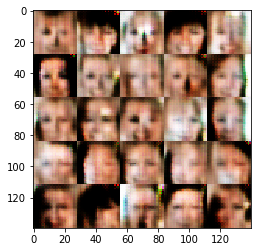

Epoch 0/1 Batch Step 820... Discriminator Loss: 0.8226... Generator Loss: 1.1358
Epoch 0/1 Batch Step 840... Discriminator Loss: 0.8263... Generator Loss: 1.1212
Epoch 0/1 Batch Step 860... Discriminator Loss: 0.3963... Generator Loss: 3.1247
Epoch 0/1 Batch Step 880... Discriminator Loss: 0.6181... Generator Loss: 2.2395
Epoch 0/1 Batch Step 900... Discriminator Loss: 0.4466... Generator Loss: 4.0578
Epoch 0/1 Batch Step 920... Discriminator Loss: 1.4561... Generator Loss: 2.2400
Epoch 0/1 Batch Step 940... Discriminator Loss: 0.3897... Generator Loss: 3.5965
Epoch 0/1 Batch Step 960... Discriminator Loss: 2.2279... Generator Loss: 0.2076
Epoch 0/1 Batch Step 980... Discriminator Loss: 0.8105... Generator Loss: 1.3832
Epoch 0/1 Batch Step 1000... Discriminator Loss: 1.2343... Generator Loss: 0.6037


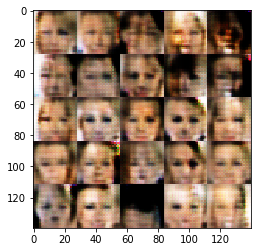

Epoch 0/1 Batch Step 1020... Discriminator Loss: 1.2362... Generator Loss: 0.8006
Epoch 0/1 Batch Step 1040... Discriminator Loss: 1.0968... Generator Loss: 1.2177
Epoch 0/1 Batch Step 1060... Discriminator Loss: 1.3777... Generator Loss: 2.1418
Epoch 0/1 Batch Step 1080... Discriminator Loss: 0.8712... Generator Loss: 1.2338
Epoch 0/1 Batch Step 1100... Discriminator Loss: 1.0794... Generator Loss: 0.8407
Epoch 0/1 Batch Step 1120... Discriminator Loss: 1.0114... Generator Loss: 1.1824
Epoch 0/1 Batch Step 1140... Discriminator Loss: 0.4514... Generator Loss: 2.9533
Epoch 0/1 Batch Step 1160... Discriminator Loss: 1.1354... Generator Loss: 0.7802
Epoch 0/1 Batch Step 1180... Discriminator Loss: 0.7263... Generator Loss: 1.3794
Epoch 0/1 Batch Step 1200... Discriminator Loss: 1.1137... Generator Loss: 0.7488


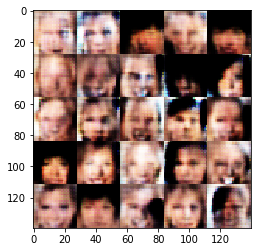

Epoch 0/1 Batch Step 1220... Discriminator Loss: 1.1071... Generator Loss: 0.8113
Epoch 0/1 Batch Step 1240... Discriminator Loss: 0.7656... Generator Loss: 1.9122
Epoch 0/1 Batch Step 1260... Discriminator Loss: 1.0953... Generator Loss: 0.8643
Epoch 0/1 Batch Step 1280... Discriminator Loss: 0.5066... Generator Loss: 2.1536
Epoch 0/1 Batch Step 1300... Discriminator Loss: 0.6003... Generator Loss: 3.6900
Epoch 0/1 Batch Step 1320... Discriminator Loss: 0.5403... Generator Loss: 1.9058
Epoch 0/1 Batch Step 1340... Discriminator Loss: 0.6736... Generator Loss: 1.7408
Epoch 0/1 Batch Step 1360... Discriminator Loss: 2.3467... Generator Loss: 3.5575
Epoch 0/1 Batch Step 1380... Discriminator Loss: 1.5251... Generator Loss: 0.4308
Epoch 0/1 Batch Step 1400... Discriminator Loss: 0.7388... Generator Loss: 2.5100


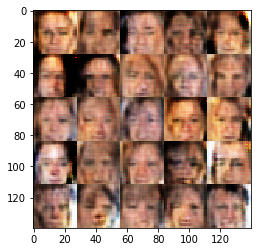

Epoch 0/1 Batch Step 1420... Discriminator Loss: 1.5168... Generator Loss: 0.4368
Epoch 0/1 Batch Step 1440... Discriminator Loss: 1.2097... Generator Loss: 2.4126
Epoch 0/1 Batch Step 1460... Discriminator Loss: 1.1521... Generator Loss: 0.7598
Epoch 0/1 Batch Step 1480... Discriminator Loss: 1.2830... Generator Loss: 1.8476
Epoch 0/1 Batch Step 1500... Discriminator Loss: 1.4724... Generator Loss: 0.4858
Epoch 0/1 Batch Step 1520... Discriminator Loss: 0.8916... Generator Loss: 1.4468
Epoch 0/1 Batch Step 1540... Discriminator Loss: 0.7733... Generator Loss: 1.3035
Epoch 0/1 Batch Step 1560... Discriminator Loss: 1.1276... Generator Loss: 0.8934
Epoch 0/1 Batch Step 1580... Discriminator Loss: 1.6326... Generator Loss: 2.3995
Epoch 0/1 Batch Step 1600... Discriminator Loss: 0.8560... Generator Loss: 1.0527


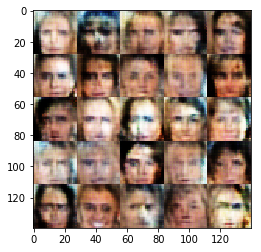

Epoch 0/1 Batch Step 1620... Discriminator Loss: 0.5440... Generator Loss: 1.9966
Epoch 0/1 Batch Step 1640... Discriminator Loss: 0.4962... Generator Loss: 2.4513
Epoch 0/1 Batch Step 1660... Discriminator Loss: 0.6247... Generator Loss: 1.6164
Epoch 0/1 Batch Step 1680... Discriminator Loss: 0.5135... Generator Loss: 2.0601
Epoch 0/1 Batch Step 1700... Discriminator Loss: 2.1681... Generator Loss: 0.2121
Epoch 0/1 Batch Step 1720... Discriminator Loss: 0.9998... Generator Loss: 1.1283
Epoch 0/1 Batch Step 1740... Discriminator Loss: 0.7375... Generator Loss: 1.3412
Epoch 0/1 Batch Step 1760... Discriminator Loss: 1.2884... Generator Loss: 0.6883
Epoch 0/1 Batch Step 1780... Discriminator Loss: 1.2329... Generator Loss: 0.7261
Epoch 0/1 Batch Step 1800... Discriminator Loss: 1.1736... Generator Loss: 0.7520


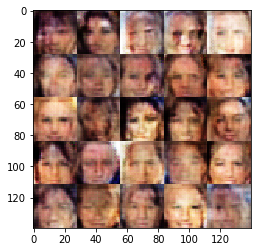

Epoch 0/1 Batch Step 1820... Discriminator Loss: 1.7497... Generator Loss: 0.3552
Epoch 0/1 Batch Step 1840... Discriminator Loss: 1.4134... Generator Loss: 0.5727
Epoch 0/1 Batch Step 1860... Discriminator Loss: 1.6963... Generator Loss: 0.3661
Epoch 0/1 Batch Step 1880... Discriminator Loss: 1.2079... Generator Loss: 0.9436
Epoch 0/1 Batch Step 1900... Discriminator Loss: 2.0283... Generator Loss: 2.6671
Epoch 0/1 Batch Step 1920... Discriminator Loss: 2.0211... Generator Loss: 0.2315
Epoch 0/1 Batch Step 1940... Discriminator Loss: 1.2069... Generator Loss: 0.8236
Epoch 0/1 Batch Step 1960... Discriminator Loss: 1.1682... Generator Loss: 0.9613
Epoch 0/1 Batch Step 1980... Discriminator Loss: 1.7732... Generator Loss: 0.3489
Epoch 0/1 Batch Step 2000... Discriminator Loss: 1.1363... Generator Loss: 0.7720


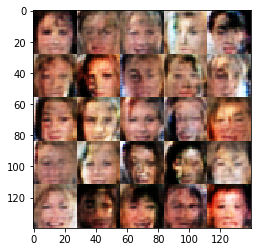

Epoch 0/1 Batch Step 2020... Discriminator Loss: 1.2388... Generator Loss: 1.0607
Epoch 0/1 Batch Step 2040... Discriminator Loss: 1.2098... Generator Loss: 0.6074
Epoch 0/1 Batch Step 2060... Discriminator Loss: 1.0682... Generator Loss: 0.9705
Epoch 0/1 Batch Step 2080... Discriminator Loss: 1.3794... Generator Loss: 0.5323
Epoch 0/1 Batch Step 2100... Discriminator Loss: 1.1263... Generator Loss: 0.8970
Epoch 0/1 Batch Step 2120... Discriminator Loss: 1.2047... Generator Loss: 0.9729
Epoch 0/1 Batch Step 2140... Discriminator Loss: 1.1105... Generator Loss: 0.7744
Epoch 0/1 Batch Step 2160... Discriminator Loss: 1.2960... Generator Loss: 0.5885
Epoch 0/1 Batch Step 2180... Discriminator Loss: 1.5093... Generator Loss: 0.4617
Epoch 0/1 Batch Step 2200... Discriminator Loss: 1.6771... Generator Loss: 0.4847


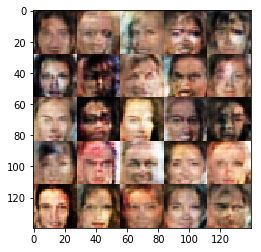

Epoch 0/1 Batch Step 2220... Discriminator Loss: 1.9774... Generator Loss: 0.2882
Epoch 0/1 Batch Step 2240... Discriminator Loss: 1.1510... Generator Loss: 1.2946
Epoch 0/1 Batch Step 2260... Discriminator Loss: 1.1704... Generator Loss: 0.6968
Epoch 0/1 Batch Step 2280... Discriminator Loss: 1.4525... Generator Loss: 0.5699
Epoch 0/1 Batch Step 2300... Discriminator Loss: 1.2526... Generator Loss: 0.8402
Epoch 0/1 Batch Step 2320... Discriminator Loss: 1.0394... Generator Loss: 1.2071
Epoch 0/1 Batch Step 2340... Discriminator Loss: 2.4306... Generator Loss: 0.2264
Epoch 0/1 Batch Step 2360... Discriminator Loss: 1.3588... Generator Loss: 0.8640
Epoch 0/1 Batch Step 2380... Discriminator Loss: 1.1353... Generator Loss: 0.8157
Epoch 0/1 Batch Step 2400... Discriminator Loss: 1.1568... Generator Loss: 1.2950


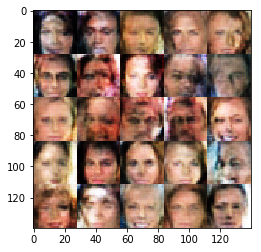

Epoch 0/1 Batch Step 2420... Discriminator Loss: 1.0764... Generator Loss: 1.2600
Epoch 0/1 Batch Step 2440... Discriminator Loss: 1.0325... Generator Loss: 0.9200
Epoch 0/1 Batch Step 2460... Discriminator Loss: 1.1697... Generator Loss: 0.7921
Epoch 0/1 Batch Step 2480... Discriminator Loss: 1.2967... Generator Loss: 0.6635
Epoch 0/1 Batch Step 2500... Discriminator Loss: 1.3136... Generator Loss: 0.6355
Epoch 0/1 Batch Step 2520... Discriminator Loss: 1.4875... Generator Loss: 0.4570
Epoch 0/1 Batch Step 2540... Discriminator Loss: 1.5192... Generator Loss: 0.5148
Epoch 0/1 Batch Step 2560... Discriminator Loss: 1.3022... Generator Loss: 0.7935
Epoch 0/1 Batch Step 2580... Discriminator Loss: 0.9822... Generator Loss: 1.0754
Epoch 0/1 Batch Step 2600... Discriminator Loss: 1.1972... Generator Loss: 0.7807


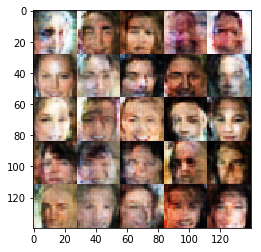

Epoch 0/1 Batch Step 2620... Discriminator Loss: 1.9018... Generator Loss: 2.4206
Epoch 0/1 Batch Step 2640... Discriminator Loss: 1.2615... Generator Loss: 0.7086
Epoch 0/1 Batch Step 2660... Discriminator Loss: 1.3070... Generator Loss: 0.5839
Epoch 0/1 Batch Step 2680... Discriminator Loss: 1.2452... Generator Loss: 0.7260
Epoch 0/1 Batch Step 2700... Discriminator Loss: 1.4438... Generator Loss: 0.9453
Epoch 0/1 Batch Step 2720... Discriminator Loss: 1.2787... Generator Loss: 0.6750
Epoch 0/1 Batch Step 2740... Discriminator Loss: 1.4662... Generator Loss: 1.5709
Epoch 0/1 Batch Step 2760... Discriminator Loss: 1.3201... Generator Loss: 0.5320
Epoch 0/1 Batch Step 2780... Discriminator Loss: 2.3488... Generator Loss: 0.1861
Epoch 0/1 Batch Step 2800... Discriminator Loss: 1.1524... Generator Loss: 1.3180


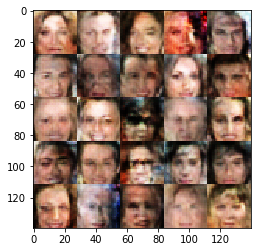

Epoch 0/1 Batch Step 2820... Discriminator Loss: 1.2288... Generator Loss: 0.6406
Epoch 0/1 Batch Step 2840... Discriminator Loss: 0.9210... Generator Loss: 1.0956
Epoch 0/1 Batch Step 2860... Discriminator Loss: 1.3627... Generator Loss: 0.5625
Epoch 0/1 Batch Step 2880... Discriminator Loss: 1.4562... Generator Loss: 0.4787
Epoch 0/1 Batch Step 2900... Discriminator Loss: 1.2662... Generator Loss: 0.5832
Epoch 0/1 Batch Step 2920... Discriminator Loss: 1.2132... Generator Loss: 0.8243
Epoch 0/1 Batch Step 2940... Discriminator Loss: 1.1698... Generator Loss: 0.8343
Epoch 0/1 Batch Step 2960... Discriminator Loss: 1.3948... Generator Loss: 0.4719
Epoch 0/1 Batch Step 2980... Discriminator Loss: 1.4204... Generator Loss: 0.4945
Epoch 0/1 Batch Step 3000... Discriminator Loss: 1.2597... Generator Loss: 0.6304


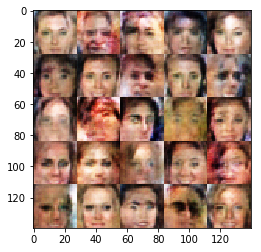

Epoch 0/1 Batch Step 3020... Discriminator Loss: 1.3383... Generator Loss: 0.6331
Epoch 0/1 Batch Step 3040... Discriminator Loss: 1.9079... Generator Loss: 0.2694
Epoch 0/1 Batch Step 3060... Discriminator Loss: 1.4804... Generator Loss: 0.5085
Epoch 0/1 Batch Step 3080... Discriminator Loss: 1.4383... Generator Loss: 0.4698
Epoch 0/1 Batch Step 3100... Discriminator Loss: 1.2268... Generator Loss: 0.6402
Epoch 0/1 Batch Step 3120... Discriminator Loss: 1.8309... Generator Loss: 0.3500
Epoch 0/1 Batch Step 3140... Discriminator Loss: 1.6231... Generator Loss: 0.3894
Epoch 0/1 Batch Step 3160... Discriminator Loss: 1.7194... Generator Loss: 0.3292
Epoch 0/1 Batch Step 3180... Discriminator Loss: 1.8766... Generator Loss: 0.2686
Epoch 0/1 Batch Step 3200... Discriminator Loss: 1.3599... Generator Loss: 0.5477


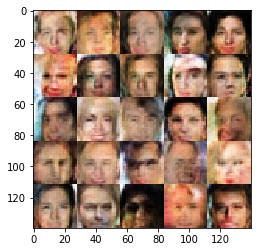

Epoch 0/1 Batch Step 3220... Discriminator Loss: 1.2794... Generator Loss: 0.6762
Epoch 0/1 Batch Step 3240... Discriminator Loss: 1.7973... Generator Loss: 0.2963
Epoch 0/1 Batch Step 3260... Discriminator Loss: 1.2905... Generator Loss: 0.6231
Epoch 0/1 Batch Step 3280... Discriminator Loss: 1.2193... Generator Loss: 0.6786
Epoch 0/1 Batch Step 3300... Discriminator Loss: 1.2117... Generator Loss: 0.7708
Epoch 0/1 Batch Step 3320... Discriminator Loss: 1.8077... Generator Loss: 1.4295
Epoch 0/1 Batch Step 3340... Discriminator Loss: 1.2671... Generator Loss: 0.6411
Epoch 0/1 Batch Step 3360... Discriminator Loss: 1.0516... Generator Loss: 0.8411
Epoch 0/1 Batch Step 3380... Discriminator Loss: 1.1284... Generator Loss: 0.7037
Epoch 0/1 Batch Step 3400... Discriminator Loss: 1.6856... Generator Loss: 0.3303


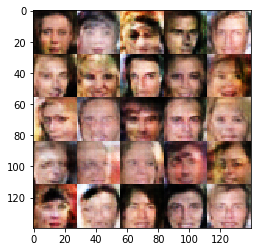

Epoch 0/1 Batch Step 3420... Discriminator Loss: 1.1014... Generator Loss: 0.7680
Epoch 0/1 Batch Step 3440... Discriminator Loss: 1.4891... Generator Loss: 0.5022
Epoch 0/1 Batch Step 3460... Discriminator Loss: 2.2839... Generator Loss: 0.1843
Epoch 0/1 Batch Step 3480... Discriminator Loss: 1.2474... Generator Loss: 0.5992
Epoch 0/1 Batch Step 3500... Discriminator Loss: 1.1387... Generator Loss: 0.6823
Epoch 0/1 Batch Step 3520... Discriminator Loss: 0.7925... Generator Loss: 1.1671
Epoch 0/1 Batch Step 3540... Discriminator Loss: 0.8687... Generator Loss: 1.3671
Epoch 0/1 Batch Step 3560... Discriminator Loss: 1.4842... Generator Loss: 0.4434
Epoch 0/1 Batch Step 3580... Discriminator Loss: 1.1354... Generator Loss: 0.7686
Epoch 0/1 Batch Step 3600... Discriminator Loss: 1.3438... Generator Loss: 0.5581


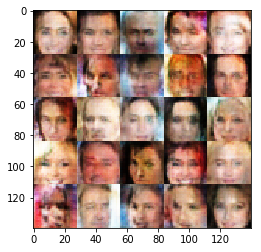

Epoch 0/1 Batch Step 3620... Discriminator Loss: 1.6889... Generator Loss: 0.4066
Epoch 0/1 Batch Step 3640... Discriminator Loss: 1.3741... Generator Loss: 0.5441
Epoch 0/1 Batch Step 3660... Discriminator Loss: 1.1809... Generator Loss: 0.6660
Epoch 0/1 Batch Step 3680... Discriminator Loss: 1.5406... Generator Loss: 0.4224
Epoch 0/1 Batch Step 3700... Discriminator Loss: 1.4344... Generator Loss: 0.4934
Epoch 0/1 Batch Step 3720... Discriminator Loss: 1.8265... Generator Loss: 0.3250
Epoch 0/1 Batch Step 3740... Discriminator Loss: 1.4462... Generator Loss: 0.4893
Epoch 0/1 Batch Step 3760... Discriminator Loss: 1.4603... Generator Loss: 0.4620
Epoch 0/1 Batch Step 3780... Discriminator Loss: 1.0917... Generator Loss: 0.7327
Epoch 0/1 Batch Step 3800... Discriminator Loss: 1.1269... Generator Loss: 0.7801


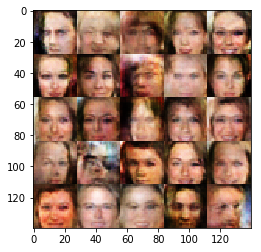

Epoch 0/1 Batch Step 3820... Discriminator Loss: 1.5176... Generator Loss: 0.4335
Epoch 0/1 Batch Step 3840... Discriminator Loss: 1.2671... Generator Loss: 1.0279
Epoch 0/1 Batch Step 3860... Discriminator Loss: 1.1161... Generator Loss: 1.0245
Epoch 0/1 Batch Step 3880... Discriminator Loss: 2.1098... Generator Loss: 0.2222
Epoch 0/1 Batch Step 3900... Discriminator Loss: 1.0645... Generator Loss: 0.9053
Epoch 0/1 Batch Step 3920... Discriminator Loss: 1.2330... Generator Loss: 0.6414
Epoch 0/1 Batch Step 3940... Discriminator Loss: 1.3846... Generator Loss: 0.5196
Epoch 0/1 Batch Step 3960... Discriminator Loss: 1.3639... Generator Loss: 0.5241
Epoch 0/1 Batch Step 3980... Discriminator Loss: 2.1823... Generator Loss: 0.1979
Epoch 0/1 Batch Step 4000... Discriminator Loss: 1.6623... Generator Loss: 0.3839


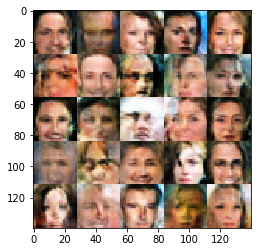

Epoch 0/1 Batch Step 4020... Discriminator Loss: 1.1367... Generator Loss: 0.8385
Epoch 0/1 Batch Step 4040... Discriminator Loss: 1.7126... Generator Loss: 0.3795
Epoch 0/1 Batch Step 4060... Discriminator Loss: 1.7166... Generator Loss: 0.3243
Epoch 0/1 Batch Step 4080... Discriminator Loss: 1.1421... Generator Loss: 0.8229
Epoch 0/1 Batch Step 4100... Discriminator Loss: 1.1847... Generator Loss: 1.3745
Epoch 0/1 Batch Step 4120... Discriminator Loss: 1.1582... Generator Loss: 0.6479
Epoch 0/1 Batch Step 4140... Discriminator Loss: 1.4425... Generator Loss: 0.4941
Epoch 0/1 Batch Step 4160... Discriminator Loss: 1.6078... Generator Loss: 0.3761
Epoch 0/1 Batch Step 4180... Discriminator Loss: 1.9557... Generator Loss: 0.2630
Epoch 0/1 Batch Step 4200... Discriminator Loss: 1.6406... Generator Loss: 0.4126


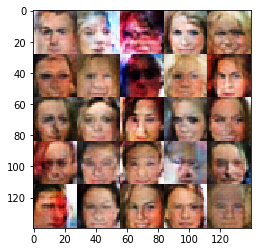

Epoch 0/1 Batch Step 4220... Discriminator Loss: 1.1713... Generator Loss: 1.3610
Epoch 0/1 Batch Step 4240... Discriminator Loss: 1.1667... Generator Loss: 1.2447
Epoch 0/1 Batch Step 4260... Discriminator Loss: 1.1750... Generator Loss: 0.5900
Epoch 0/1 Batch Step 4280... Discriminator Loss: 1.0513... Generator Loss: 0.8540
Epoch 0/1 Batch Step 4300... Discriminator Loss: 1.3706... Generator Loss: 1.3301
Epoch 0/1 Batch Step 4320... Discriminator Loss: 1.3652... Generator Loss: 0.5630
Epoch 0/1 Batch Step 4340... Discriminator Loss: 1.0788... Generator Loss: 1.0224
Epoch 0/1 Batch Step 4360... Discriminator Loss: 1.7441... Generator Loss: 0.3455
Epoch 0/1 Batch Step 4380... Discriminator Loss: 1.0954... Generator Loss: 1.0763
Epoch 0/1 Batch Step 4400... Discriminator Loss: 1.3560... Generator Loss: 0.5209


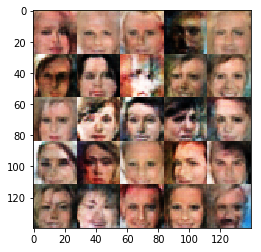

Epoch 0/1 Batch Step 4420... Discriminator Loss: 2.3720... Generator Loss: 0.1816
Epoch 0/1 Batch Step 4440... Discriminator Loss: 1.6392... Generator Loss: 0.3699
Epoch 0/1 Batch Step 4460... Discriminator Loss: 1.1475... Generator Loss: 0.6670
Epoch 0/1 Batch Step 4480... Discriminator Loss: 2.0588... Generator Loss: 0.2410
Epoch 0/1 Batch Step 4500... Discriminator Loss: 1.2492... Generator Loss: 0.6044
Epoch 0/1 Batch Step 4520... Discriminator Loss: 2.1211... Generator Loss: 0.2195
Epoch 0/1 Batch Step 4540... Discriminator Loss: 1.1554... Generator Loss: 0.6402
Epoch 0/1 Batch Step 4560... Discriminator Loss: 1.5641... Generator Loss: 1.7161
Epoch 0/1 Batch Step 4580... Discriminator Loss: 1.3390... Generator Loss: 0.5205
Epoch 0/1 Batch Step 4600... Discriminator Loss: 1.4326... Generator Loss: 0.4857


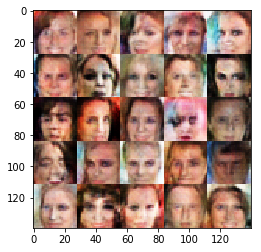

Epoch 0/1 Batch Step 4620... Discriminator Loss: 1.0307... Generator Loss: 0.8697
Epoch 0/1 Batch Step 4640... Discriminator Loss: 1.3325... Generator Loss: 1.6745
Epoch 0/1 Batch Step 4660... Discriminator Loss: 1.3200... Generator Loss: 1.5935
Epoch 0/1 Batch Step 4680... Discriminator Loss: 1.0662... Generator Loss: 0.7618
Epoch 0/1 Batch Step 4700... Discriminator Loss: 2.4927... Generator Loss: 2.4813
Epoch 0/1 Batch Step 4720... Discriminator Loss: 1.0591... Generator Loss: 0.9598
Epoch 0/1 Batch Step 4740... Discriminator Loss: 0.9280... Generator Loss: 0.9787
Epoch 0/1 Batch Step 4760... Discriminator Loss: 1.2697... Generator Loss: 0.6014
Epoch 0/1 Batch Step 4780... Discriminator Loss: 1.2102... Generator Loss: 0.6408
Epoch 0/1 Batch Step 4800... Discriminator Loss: 0.9674... Generator Loss: 0.8095


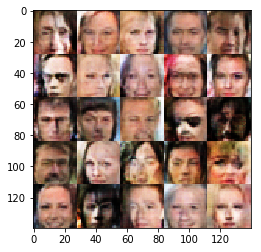

Epoch 0/1 Batch Step 4820... Discriminator Loss: 1.0314... Generator Loss: 0.7951
Epoch 0/1 Batch Step 4840... Discriminator Loss: 1.5503... Generator Loss: 0.4045
Epoch 0/1 Batch Step 4860... Discriminator Loss: 0.7374... Generator Loss: 1.3337
Epoch 0/1 Batch Step 4880... Discriminator Loss: 1.3090... Generator Loss: 0.5250
Epoch 0/1 Batch Step 4900... Discriminator Loss: 1.1369... Generator Loss: 0.9867
Epoch 0/1 Batch Step 4920... Discriminator Loss: 1.4733... Generator Loss: 0.4691
Epoch 0/1 Batch Step 4940... Discriminator Loss: 1.1112... Generator Loss: 0.7125
Epoch 0/1 Batch Step 4960... Discriminator Loss: 1.6487... Generator Loss: 0.3532
Epoch 0/1 Batch Step 4980... Discriminator Loss: 1.1920... Generator Loss: 1.8051
Epoch 0/1 Batch Step 5000... Discriminator Loss: 1.1688... Generator Loss: 0.9591


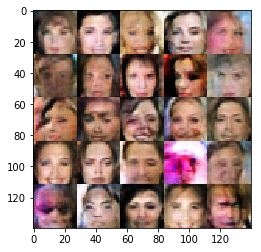

Epoch 0/1 Batch Step 5020... Discriminator Loss: 1.0673... Generator Loss: 0.8586
Epoch 0/1 Batch Step 5040... Discriminator Loss: 2.5411... Generator Loss: 0.1476
Epoch 0/1 Batch Step 5060... Discriminator Loss: 1.0210... Generator Loss: 1.1987
Epoch 0/1 Batch Step 5080... Discriminator Loss: 1.0272... Generator Loss: 0.8603
Epoch 0/1 Batch Step 5100... Discriminator Loss: 1.7096... Generator Loss: 0.3507
Epoch 0/1 Batch Step 5120... Discriminator Loss: 0.8968... Generator Loss: 1.5321
Epoch 0/1 Batch Step 5140... Discriminator Loss: 0.9587... Generator Loss: 1.0196
Epoch 0/1 Batch Step 5160... Discriminator Loss: 1.1100... Generator Loss: 0.7682
Epoch 0/1 Batch Step 5180... Discriminator Loss: 1.5201... Generator Loss: 0.8504
Epoch 0/1 Batch Step 5200... Discriminator Loss: 0.7983... Generator Loss: 1.1621


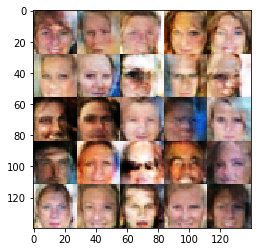

Epoch 0/1 Batch Step 5220... Discriminator Loss: 1.5681... Generator Loss: 0.4447
Epoch 0/1 Batch Step 5240... Discriminator Loss: 1.7887... Generator Loss: 0.2964
Epoch 0/1 Batch Step 5260... Discriminator Loss: 1.5556... Generator Loss: 0.4447
Epoch 0/1 Batch Step 5280... Discriminator Loss: 1.0278... Generator Loss: 0.8169
Epoch 0/1 Batch Step 5300... Discriminator Loss: 0.8062... Generator Loss: 1.0650
Epoch 0/1 Batch Step 5320... Discriminator Loss: 1.2753... Generator Loss: 0.5648
Epoch 0/1 Batch Step 5340... Discriminator Loss: 1.1606... Generator Loss: 0.7932
Epoch 0/1 Batch Step 5360... Discriminator Loss: 1.1263... Generator Loss: 0.9265
Epoch 0/1 Batch Step 5380... Discriminator Loss: 1.4066... Generator Loss: 0.4623
Epoch 0/1 Batch Step 5400... Discriminator Loss: 1.2854... Generator Loss: 0.5889


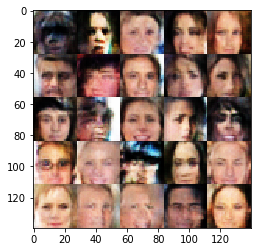

Epoch 0/1 Batch Step 5420... Discriminator Loss: 1.5639... Generator Loss: 0.4429
Epoch 0/1 Batch Step 5440... Discriminator Loss: 1.2708... Generator Loss: 0.5407
Epoch 0/1 Batch Step 5460... Discriminator Loss: 1.6294... Generator Loss: 0.4068
Epoch 0/1 Batch Step 5480... Discriminator Loss: 1.0041... Generator Loss: 1.1456
Epoch 0/1 Batch Step 5500... Discriminator Loss: 1.4428... Generator Loss: 0.5058
Epoch 0/1 Batch Step 5520... Discriminator Loss: 1.2661... Generator Loss: 0.7007
Epoch 0/1 Batch Step 5540... Discriminator Loss: 1.2975... Generator Loss: 0.5643
Epoch 0/1 Batch Step 5560... Discriminator Loss: 2.1302... Generator Loss: 0.2106
Epoch 0/1 Batch Step 5580... Discriminator Loss: 1.4793... Generator Loss: 0.4203
Epoch 0/1 Batch Step 5600... Discriminator Loss: 1.1803... Generator Loss: 0.6254


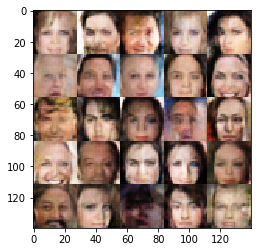

Epoch 0/1 Batch Step 5620... Discriminator Loss: 1.0485... Generator Loss: 0.7680
Epoch 0/1 Batch Step 5640... Discriminator Loss: 1.1461... Generator Loss: 0.7050
Epoch 0/1 Batch Step 5660... Discriminator Loss: 1.3616... Generator Loss: 0.8524
Epoch 0/1 Batch Step 5680... Discriminator Loss: 0.9041... Generator Loss: 0.9987
Epoch 0/1 Batch Step 5700... Discriminator Loss: 1.1379... Generator Loss: 0.7708
Epoch 0/1 Batch Step 5720... Discriminator Loss: 1.2687... Generator Loss: 0.6601
Epoch 0/1 Batch Step 5740... Discriminator Loss: 1.6029... Generator Loss: 0.4570
Epoch 0/1 Batch Step 5760... Discriminator Loss: 1.2926... Generator Loss: 0.5330
Epoch 0/1 Batch Step 5780... Discriminator Loss: 1.3957... Generator Loss: 0.4713
Epoch 0/1 Batch Step 5800... Discriminator Loss: 1.3824... Generator Loss: 0.9761


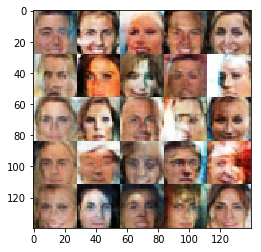

Epoch 0/1 Batch Step 5820... Discriminator Loss: 0.5697... Generator Loss: 1.7961
Epoch 0/1 Batch Step 5840... Discriminator Loss: 0.8758... Generator Loss: 0.9929
Epoch 0/1 Batch Step 5860... Discriminator Loss: 1.3020... Generator Loss: 0.6756
Epoch 0/1 Batch Step 5880... Discriminator Loss: 1.4446... Generator Loss: 0.5160
Epoch 0/1 Batch Step 5900... Discriminator Loss: 1.3467... Generator Loss: 0.5990
Epoch 0/1 Batch Step 5920... Discriminator Loss: 1.7137... Generator Loss: 0.3209
Epoch 0/1 Batch Step 5940... Discriminator Loss: 1.3120... Generator Loss: 0.6772
Epoch 0/1 Batch Step 5960... Discriminator Loss: 1.2551... Generator Loss: 0.7203
Epoch 0/1 Batch Step 5980... Discriminator Loss: 1.7846... Generator Loss: 0.3452
Epoch 0/1 Batch Step 6000... Discriminator Loss: 1.3634... Generator Loss: 0.5166


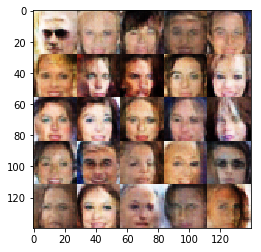

Epoch 0/1 Batch Step 6020... Discriminator Loss: 1.2302... Generator Loss: 1.5072
Epoch 0/1 Batch Step 6040... Discriminator Loss: 1.5454... Generator Loss: 0.4587
Epoch 0/1 Batch Step 6060... Discriminator Loss: 1.4088... Generator Loss: 0.4866
Epoch 0/1 Batch Step 6080... Discriminator Loss: 1.2865... Generator Loss: 0.6517
Epoch 0/1 Batch Step 6100... Discriminator Loss: 1.3130... Generator Loss: 0.6011
Epoch 0/1 Batch Step 6120... Discriminator Loss: 1.2416... Generator Loss: 1.0557
Epoch 0/1 Batch Step 6140... Discriminator Loss: 1.5511... Generator Loss: 0.4155
Epoch 0/1 Batch Step 6160... Discriminator Loss: 1.4871... Generator Loss: 0.4876
Epoch 0/1 Batch Step 6180... Discriminator Loss: 1.6434... Generator Loss: 0.3746
Epoch 0/1 Batch Step 6200... Discriminator Loss: 1.1569... Generator Loss: 0.7216


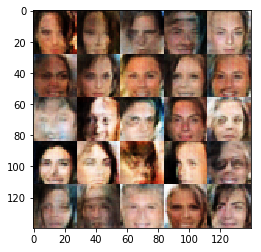

Epoch 0/1 Batch Step 6220... Discriminator Loss: 1.1101... Generator Loss: 1.4064
Epoch 0/1 Batch Step 6240... Discriminator Loss: 1.1746... Generator Loss: 0.6239
Epoch 0/1 Batch Step 6260... Discriminator Loss: 0.9961... Generator Loss: 0.8888
Epoch 0/1 Batch Step 6280... Discriminator Loss: 1.6032... Generator Loss: 1.6336
Epoch 0/1 Batch Step 6300... Discriminator Loss: 0.7546... Generator Loss: 1.6924
Epoch 0/1 Batch Step 6320... Discriminator Loss: 1.3043... Generator Loss: 0.7210
Epoch 0/1 Batch Step 6340... Discriminator Loss: 1.1642... Generator Loss: 0.7949
Epoch 0/1 Batch Step 6360... Discriminator Loss: 1.1249... Generator Loss: 0.8719
Epoch 0/1 Batch Step 6380... Discriminator Loss: 1.4416... Generator Loss: 0.4909
Epoch 0/1 Batch Step 6400... Discriminator Loss: 1.0215... Generator Loss: 1.0241


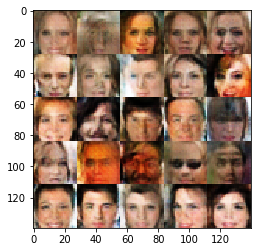

Epoch 0/1 Batch Step 6420... Discriminator Loss: 1.9609... Generator Loss: 0.2672
Epoch 0/1 Batch Step 6440... Discriminator Loss: 1.8048... Generator Loss: 0.3084
Epoch 0/1 Batch Step 6460... Discriminator Loss: 1.0750... Generator Loss: 0.8157
Epoch 0/1 Batch Step 6480... Discriminator Loss: 1.5934... Generator Loss: 0.3573
Epoch 0/1 Batch Step 6500... Discriminator Loss: 1.3954... Generator Loss: 0.5607
Epoch 0/1 Batch Step 6520... Discriminator Loss: 2.6316... Generator Loss: 0.1489
Epoch 0/1 Batch Step 6540... Discriminator Loss: 1.2211... Generator Loss: 0.6346
Epoch 0/1 Batch Step 6560... Discriminator Loss: 0.9139... Generator Loss: 1.0975
Epoch 0/1 Batch Step 6580... Discriminator Loss: 1.5993... Generator Loss: 0.3623
Epoch 0/1 Batch Step 6600... Discriminator Loss: 1.1454... Generator Loss: 0.8615


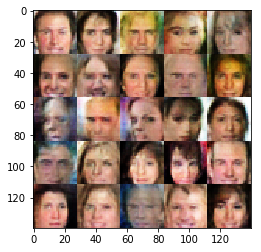

Epoch 0/1 Batch Step 6620... Discriminator Loss: 1.0655... Generator Loss: 0.8937
Epoch 0/1 Batch Step 6640... Discriminator Loss: 1.0519... Generator Loss: 0.9840
Epoch 0/1 Batch Step 6660... Discriminator Loss: 0.7098... Generator Loss: 1.3226
Epoch 0/1 Batch Step 6680... Discriminator Loss: 2.5066... Generator Loss: 0.1569
Epoch 0/1 Batch Step 6700... Discriminator Loss: 1.1801... Generator Loss: 0.7256
Epoch 0/1 Batch Step 6720... Discriminator Loss: 1.1773... Generator Loss: 0.7386
Epoch 0/1 Batch Step 6740... Discriminator Loss: 1.2205... Generator Loss: 0.6229
Epoch 0/1 Batch Step 6760... Discriminator Loss: 1.2876... Generator Loss: 1.4212
Epoch 0/1 Batch Step 6780... Discriminator Loss: 1.2765... Generator Loss: 0.5532
Epoch 0/1 Batch Step 6800... Discriminator Loss: 1.2357... Generator Loss: 0.6439


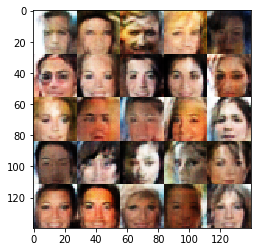

Epoch 0/1 Batch Step 6820... Discriminator Loss: 1.6286... Generator Loss: 0.4486
Epoch 0/1 Batch Step 6840... Discriminator Loss: 1.0349... Generator Loss: 1.2364
Epoch 0/1 Batch Step 6860... Discriminator Loss: 0.7336... Generator Loss: 1.4835
Epoch 0/1 Batch Step 6880... Discriminator Loss: 1.8596... Generator Loss: 0.2955
Epoch 0/1 Batch Step 6900... Discriminator Loss: 1.2270... Generator Loss: 0.8495
Epoch 0/1 Batch Step 6920... Discriminator Loss: 1.8754... Generator Loss: 0.4241
Epoch 0/1 Batch Step 6940... Discriminator Loss: 0.5071... Generator Loss: 2.1704
Epoch 0/1 Batch Step 6960... Discriminator Loss: 0.6672... Generator Loss: 1.9562
Epoch 0/1 Batch Step 6980... Discriminator Loss: 0.7591... Generator Loss: 1.2923
Epoch 0/1 Batch Step 7000... Discriminator Loss: 0.4968... Generator Loss: 2.0601


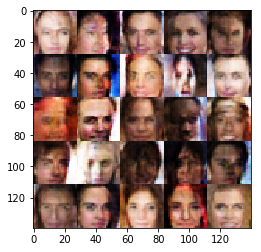

Epoch 0/1 Batch Step 7020... Discriminator Loss: 1.2417... Generator Loss: 1.0350
Epoch 0/1 Batch Step 7040... Discriminator Loss: 1.3844... Generator Loss: 0.5059
Epoch 0/1 Batch Step 7060... Discriminator Loss: 0.9496... Generator Loss: 1.0057
Epoch 0/1 Batch Step 7080... Discriminator Loss: 1.5593... Generator Loss: 0.3912
Epoch 0/1 Batch Step 7100... Discriminator Loss: 1.6458... Generator Loss: 0.3939
Epoch 0/1 Batch Step 7120... Discriminator Loss: 1.6382... Generator Loss: 0.4593
Epoch 0/1 Batch Step 7140... Discriminator Loss: 1.0407... Generator Loss: 1.0246
Epoch 0/1 Batch Step 7160... Discriminator Loss: 1.2855... Generator Loss: 1.9040
Epoch 0/1 Batch Step 7180... Discriminator Loss: 1.3218... Generator Loss: 1.0009
Epoch 0/1 Batch Step 7200... Discriminator Loss: 0.7857... Generator Loss: 1.0838


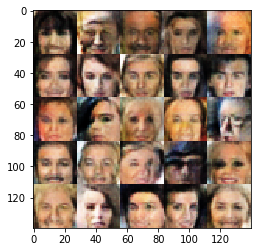

Epoch 0/1 Batch Step 7220... Discriminator Loss: 0.8770... Generator Loss: 1.3569
Epoch 0/1 Batch Step 7240... Discriminator Loss: 0.9494... Generator Loss: 0.9623
Epoch 0/1 Batch Step 7260... Discriminator Loss: 0.7791... Generator Loss: 1.1690
Epoch 0/1 Batch Step 7280... Discriminator Loss: 0.7773... Generator Loss: 1.0854
Epoch 0/1 Batch Step 7300... Discriminator Loss: 1.6585... Generator Loss: 0.3722
Epoch 0/1 Batch Step 7320... Discriminator Loss: 1.5866... Generator Loss: 0.3677
Epoch 0/1 Batch Step 7340... Discriminator Loss: 1.7467... Generator Loss: 0.3695
Epoch 0/1 Batch Step 7360... Discriminator Loss: 1.4826... Generator Loss: 0.4073
Epoch 0/1 Batch Step 7380... Discriminator Loss: 1.3855... Generator Loss: 0.4997
Epoch 0/1 Batch Step 7400... Discriminator Loss: 2.0319... Generator Loss: 1.4723


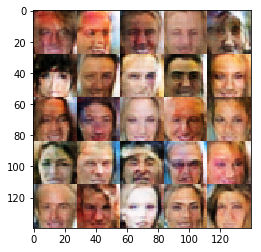

Epoch 0/1 Batch Step 7420... Discriminator Loss: 1.2631... Generator Loss: 0.6201
Epoch 0/1 Batch Step 7440... Discriminator Loss: 1.0013... Generator Loss: 1.7314
Epoch 0/1 Batch Step 7460... Discriminator Loss: 0.7887... Generator Loss: 1.2710
Epoch 0/1 Batch Step 7480... Discriminator Loss: 1.3377... Generator Loss: 1.0670
Epoch 0/1 Batch Step 7500... Discriminator Loss: 1.3072... Generator Loss: 0.5582
Epoch 0/1 Batch Step 7520... Discriminator Loss: 1.3094... Generator Loss: 1.0640
Epoch 0/1 Batch Step 7540... Discriminator Loss: 1.0057... Generator Loss: 0.8772
Epoch 0/1 Batch Step 7560... Discriminator Loss: 1.7153... Generator Loss: 1.4187
Epoch 0/1 Batch Step 7580... Discriminator Loss: 1.2190... Generator Loss: 0.6024
Epoch 0/1 Batch Step 7600... Discriminator Loss: 1.4195... Generator Loss: 0.5973


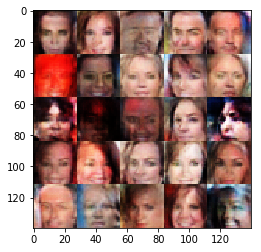

Epoch 0/1 Batch Step 7620... Discriminator Loss: 1.0920... Generator Loss: 1.1093
Epoch 0/1 Batch Step 7640... Discriminator Loss: 1.4087... Generator Loss: 0.5490
Epoch 0/1 Batch Step 7660... Discriminator Loss: 1.2663... Generator Loss: 0.6463
Epoch 0/1 Batch Step 7680... Discriminator Loss: 1.4314... Generator Loss: 0.4874
Epoch 0/1 Batch Step 7700... Discriminator Loss: 1.1015... Generator Loss: 0.6716
Epoch 0/1 Batch Step 7720... Discriminator Loss: 1.3865... Generator Loss: 0.6366
Epoch 0/1 Batch Step 7740... Discriminator Loss: 0.9122... Generator Loss: 1.0775
Epoch 0/1 Batch Step 7760... Discriminator Loss: 1.2700... Generator Loss: 0.6134
Epoch 0/1 Batch Step 7780... Discriminator Loss: 1.3306... Generator Loss: 0.7603
Epoch 0/1 Batch Step 7800... Discriminator Loss: 1.2562... Generator Loss: 1.0632


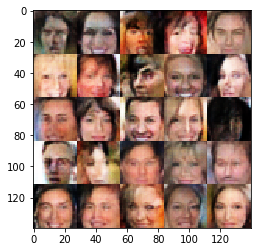

Epoch 0/1 Batch Step 7820... Discriminator Loss: 1.2589... Generator Loss: 0.8036
Epoch 0/1 Batch Step 7840... Discriminator Loss: 1.4313... Generator Loss: 0.5132
Epoch 0/1 Batch Step 7860... Discriminator Loss: 1.3607... Generator Loss: 0.5604
Epoch 0/1 Batch Step 7880... Discriminator Loss: 1.3216... Generator Loss: 0.5812
Epoch 0/1 Batch Step 7900... Discriminator Loss: 1.1037... Generator Loss: 0.9068
Epoch 0/1 Batch Step 7920... Discriminator Loss: 1.9998... Generator Loss: 0.2399
Epoch 0/1 Batch Step 7940... Discriminator Loss: 1.1698... Generator Loss: 0.6216
Epoch 0/1 Batch Step 7960... Discriminator Loss: 1.1931... Generator Loss: 2.3766
Epoch 0/1 Batch Step 7980... Discriminator Loss: 1.4393... Generator Loss: 0.4933
Epoch 0/1 Batch Step 8000... Discriminator Loss: 1.3961... Generator Loss: 0.4807


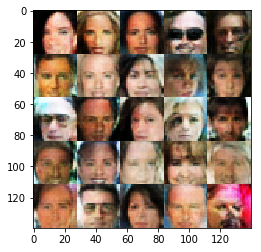

Epoch 0/1 Batch Step 8020... Discriminator Loss: 2.0557... Generator Loss: 1.6276
Epoch 0/1 Batch Step 8040... Discriminator Loss: 1.0886... Generator Loss: 1.2259
Epoch 0/1 Batch Step 8060... Discriminator Loss: 0.7161... Generator Loss: 1.2706
Epoch 0/1 Batch Step 8080... Discriminator Loss: 0.9484... Generator Loss: 0.8244
Epoch 0/1 Batch Step 8100... Discriminator Loss: 0.8148... Generator Loss: 1.1838
Epoch 0/1 Batch Step 8120... Discriminator Loss: 1.9284... Generator Loss: 1.4550
Epoch 0/1 Batch Step 8140... Discriminator Loss: 3.9266... Generator Loss: 0.0397
Epoch 0/1 Batch Step 8160... Discriminator Loss: 1.3700... Generator Loss: 0.5460
Epoch 0/1 Batch Step 8180... Discriminator Loss: 1.2382... Generator Loss: 0.7956
Epoch 0/1 Batch Step 8200... Discriminator Loss: 1.0360... Generator Loss: 0.9736


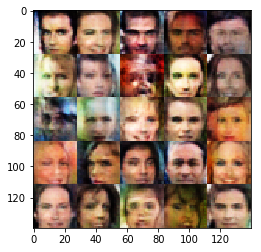

Epoch 0/1 Batch Step 8220... Discriminator Loss: 1.2728... Generator Loss: 0.5882
Epoch 0/1 Batch Step 8240... Discriminator Loss: 1.5399... Generator Loss: 0.3847
Epoch 0/1 Batch Step 8260... Discriminator Loss: 1.4161... Generator Loss: 0.7422
Epoch 0/1 Batch Step 8280... Discriminator Loss: 1.3418... Generator Loss: 1.7326
Epoch 0/1 Batch Step 8300... Discriminator Loss: 1.2163... Generator Loss: 0.8235
Epoch 0/1 Batch Step 8320... Discriminator Loss: 1.2268... Generator Loss: 0.6888
Epoch 0/1 Batch Step 8340... Discriminator Loss: 1.0341... Generator Loss: 1.1554
Epoch 0/1 Batch Step 8360... Discriminator Loss: 1.3903... Generator Loss: 0.5011
Epoch 0/1 Batch Step 8380... Discriminator Loss: 1.3476... Generator Loss: 0.5328
Epoch 0/1 Batch Step 8400... Discriminator Loss: 1.1635... Generator Loss: 0.7143


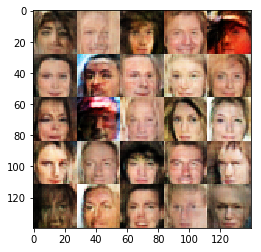

Epoch 0/1 Batch Step 8420... Discriminator Loss: 0.8813... Generator Loss: 2.7802
Epoch 0/1 Batch Step 8440... Discriminator Loss: 1.0889... Generator Loss: 0.8679
Epoch 0/1 Batch Step 8460... Discriminator Loss: 1.4931... Generator Loss: 0.4299
Epoch 0/1 Batch Step 8480... Discriminator Loss: 1.1734... Generator Loss: 0.7050
Epoch 0/1 Batch Step 8500... Discriminator Loss: 1.3737... Generator Loss: 0.5678
Epoch 0/1 Batch Step 8520... Discriminator Loss: 1.0674... Generator Loss: 0.8518
Epoch 0/1 Batch Step 8540... Discriminator Loss: 1.0652... Generator Loss: 0.9107
Epoch 0/1 Batch Step 8560... Discriminator Loss: 2.0765... Generator Loss: 0.2538
Epoch 0/1 Batch Step 8580... Discriminator Loss: 0.7033... Generator Loss: 1.3712
Epoch 0/1 Batch Step 8600... Discriminator Loss: 1.0482... Generator Loss: 0.8910


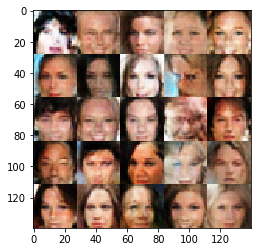

Epoch 0/1 Batch Step 8620... Discriminator Loss: 1.0930... Generator Loss: 1.0660
Epoch 0/1 Batch Step 8640... Discriminator Loss: 1.2998... Generator Loss: 0.6142
Epoch 0/1 Batch Step 8660... Discriminator Loss: 1.2931... Generator Loss: 0.5832
Epoch 0/1 Batch Step 8680... Discriminator Loss: 1.3049... Generator Loss: 0.6062
Epoch 0/1 Batch Step 8700... Discriminator Loss: 1.1654... Generator Loss: 0.8116
Epoch 0/1 Batch Step 8720... Discriminator Loss: 1.4005... Generator Loss: 0.5107
Epoch 0/1 Batch Step 8740... Discriminator Loss: 1.3877... Generator Loss: 0.5665
Epoch 0/1 Batch Step 8760... Discriminator Loss: 1.2548... Generator Loss: 0.6606
Epoch 0/1 Batch Step 8780... Discriminator Loss: 0.9671... Generator Loss: 0.8493
Epoch 0/1 Batch Step 8800... Discriminator Loss: 1.3806... Generator Loss: 0.5112


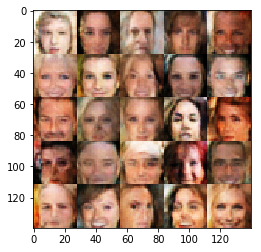

Epoch 0/1 Batch Step 8820... Discriminator Loss: 1.2692... Generator Loss: 0.6105
Epoch 0/1 Batch Step 8840... Discriminator Loss: 1.7325... Generator Loss: 0.3455
Epoch 0/1 Batch Step 8860... Discriminator Loss: 0.8440... Generator Loss: 1.5750
Epoch 0/1 Batch Step 8880... Discriminator Loss: 1.0890... Generator Loss: 0.9265
Epoch 0/1 Batch Step 8900... Discriminator Loss: 1.1822... Generator Loss: 0.8632
Epoch 0/1 Batch Step 8920... Discriminator Loss: 1.4833... Generator Loss: 0.4719
Epoch 0/1 Batch Step 8940... Discriminator Loss: 1.2399... Generator Loss: 1.0960
Epoch 0/1 Batch Step 8960... Discriminator Loss: 1.1656... Generator Loss: 0.9707
Epoch 0/1 Batch Step 8980... Discriminator Loss: 1.5750... Generator Loss: 0.3897
Epoch 0/1 Batch Step 9000... Discriminator Loss: 1.3078... Generator Loss: 0.5741


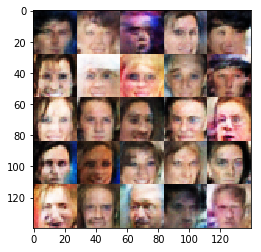

Epoch 0/1 Batch Step 9020... Discriminator Loss: 0.9100... Generator Loss: 0.9494
Epoch 0/1 Batch Step 9040... Discriminator Loss: 0.5675... Generator Loss: 2.2138
Epoch 0/1 Batch Step 9060... Discriminator Loss: 0.5590... Generator Loss: 1.8289
Epoch 0/1 Batch Step 9080... Discriminator Loss: 1.3860... Generator Loss: 0.5229
Epoch 0/1 Batch Step 9100... Discriminator Loss: 1.3263... Generator Loss: 1.3718
Epoch 0/1 Batch Step 9120... Discriminator Loss: 0.5780... Generator Loss: 1.7882
Epoch 0/1 Batch Step 9140... Discriminator Loss: 1.2837... Generator Loss: 0.6095
Epoch 0/1 Batch Step 9160... Discriminator Loss: 0.8467... Generator Loss: 1.0410
Epoch 0/1 Batch Step 9180... Discriminator Loss: 1.5406... Generator Loss: 0.4582
Epoch 0/1 Batch Step 9200... Discriminator Loss: 0.4966... Generator Loss: 2.1066


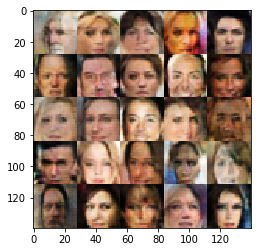

Epoch 0/1 Batch Step 9220... Discriminator Loss: 1.3436... Generator Loss: 0.7667
Epoch 0/1 Batch Step 9240... Discriminator Loss: 1.2050... Generator Loss: 0.6345
Epoch 0/1 Batch Step 9260... Discriminator Loss: 1.5168... Generator Loss: 0.3949
Epoch 0/1 Batch Step 9280... Discriminator Loss: 0.9316... Generator Loss: 1.0582
Epoch 0/1 Batch Step 9300... Discriminator Loss: 0.8272... Generator Loss: 1.0877
Epoch 0/1 Batch Step 9320... Discriminator Loss: 0.4250... Generator Loss: 2.6503
Epoch 0/1 Batch Step 9340... Discriminator Loss: 0.8177... Generator Loss: 1.0532
Epoch 0/1 Batch Step 9360... Discriminator Loss: 0.9221... Generator Loss: 0.9722
Epoch 0/1 Batch Step 9380... Discriminator Loss: 1.3790... Generator Loss: 0.4701
Epoch 0/1 Batch Step 9400... Discriminator Loss: 1.3113... Generator Loss: 0.5330


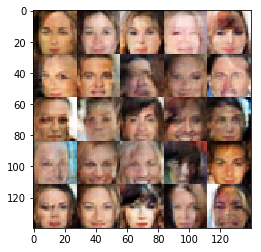

Epoch 0/1 Batch Step 9420... Discriminator Loss: 1.1970... Generator Loss: 0.6627
Epoch 0/1 Batch Step 9440... Discriminator Loss: 1.1454... Generator Loss: 0.7345
Epoch 0/1 Batch Step 9460... Discriminator Loss: 0.8323... Generator Loss: 1.0713
Epoch 0/1 Batch Step 9480... Discriminator Loss: 0.9787... Generator Loss: 1.4477
Epoch 0/1 Batch Step 9500... Discriminator Loss: 0.7868... Generator Loss: 1.1528
Epoch 0/1 Batch Step 9520... Discriminator Loss: 1.3829... Generator Loss: 0.5227
Epoch 0/1 Batch Step 9540... Discriminator Loss: 1.2284... Generator Loss: 0.6463
Epoch 0/1 Batch Step 9560... Discriminator Loss: 1.7054... Generator Loss: 0.3870
Epoch 0/1 Batch Step 9580... Discriminator Loss: 0.9565... Generator Loss: 0.9494
Epoch 0/1 Batch Step 9600... Discriminator Loss: 1.1216... Generator Loss: 1.3428


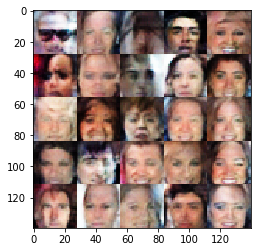

Epoch 0/1 Batch Step 9620... Discriminator Loss: 1.5093... Generator Loss: 1.0016
Epoch 0/1 Batch Step 9640... Discriminator Loss: 2.0702... Generator Loss: 0.2215
Epoch 0/1 Batch Step 9660... Discriminator Loss: 1.1076... Generator Loss: 0.6695
Epoch 0/1 Batch Step 9680... Discriminator Loss: 1.4469... Generator Loss: 0.5775
Epoch 0/1 Batch Step 9700... Discriminator Loss: 1.0630... Generator Loss: 0.7202
Epoch 0/1 Batch Step 9720... Discriminator Loss: 0.5125... Generator Loss: 2.1125
Epoch 0/1 Batch Step 9740... Discriminator Loss: 1.1382... Generator Loss: 0.6895
Epoch 0/1 Batch Step 9760... Discriminator Loss: 1.3494... Generator Loss: 1.6188
Epoch 0/1 Batch Step 9780... Discriminator Loss: 1.0980... Generator Loss: 0.8842
Epoch 0/1 Batch Step 9800... Discriminator Loss: 0.6104... Generator Loss: 3.1163


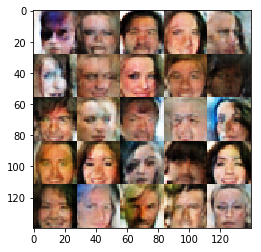

Epoch 0/1 Batch Step 9820... Discriminator Loss: 1.8746... Generator Loss: 0.3011
Epoch 0/1 Batch Step 9840... Discriminator Loss: 1.1180... Generator Loss: 1.1075
Epoch 0/1 Batch Step 9860... Discriminator Loss: 1.3365... Generator Loss: 0.5092
Epoch 0/1 Batch Step 9880... Discriminator Loss: 1.4772... Generator Loss: 0.4675
Epoch 0/1 Batch Step 9900... Discriminator Loss: 1.4619... Generator Loss: 0.5119
Epoch 0/1 Batch Step 9920... Discriminator Loss: 1.2729... Generator Loss: 0.6403
Epoch 0/1 Batch Step 9940... Discriminator Loss: 1.1815... Generator Loss: 0.7836
Epoch 0/1 Batch Step 9960... Discriminator Loss: 1.4024... Generator Loss: 0.5083
Epoch 0/1 Batch Step 9980... Discriminator Loss: 1.3797... Generator Loss: 1.2227
Epoch 0/1 Batch Step 10000... Discriminator Loss: 1.2950... Generator Loss: 0.5724


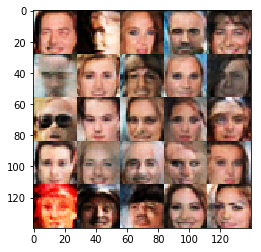

Epoch 0/1 Batch Step 10020... Discriminator Loss: 1.1196... Generator Loss: 0.9322
Epoch 0/1 Batch Step 10040... Discriminator Loss: 1.4789... Generator Loss: 0.4658
Epoch 0/1 Batch Step 10060... Discriminator Loss: 0.7184... Generator Loss: 2.0431
Epoch 0/1 Batch Step 10080... Discriminator Loss: 0.6880... Generator Loss: 1.4420
Epoch 0/1 Batch Step 10100... Discriminator Loss: 1.2825... Generator Loss: 0.6393
Epoch 0/1 Batch Step 10120... Discriminator Loss: 0.6946... Generator Loss: 1.6419
Done Training!


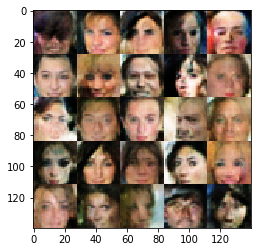

In [19]:
batch_size = 20
z_dim = 256
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

#### References
Implementation and tuning of both discriminator and generator of this project has referenced several discussion discussion threads and previous works including:
- https://discussions.udacity.com/t/all-tests-passed-but-generator-loss-is-not-improving/248040
- https://discussions.udacity.com/t/weird-generator-loss/248328
- https://discussions.udacity.com/t/adding-batch-normalization-to-discriminator-leads-to-high-generator-loss/496084/8
- https://discussions.udacity.com/t/generator-loss-seems-high/316453
- https://gist.github.com/greg-ashby/3489d1bae59b953ec43bae81880036ea
- http://www.alivelearn.net/deeplearning/dlnd_face_generation.html
- http://www.danag.co/dlnd_face_generation.html
- http://www.sai-tai.com/demos/dl/face-generation.html